# #TODO

### 1. Градиентный бустинг
0. Взять три гиперпараметра для градиентного бустинга, и для каждого проварьировать один из них, фиксируя остальные. Построить графики зависимости метрики на кросс-валидации от параметра. Прокомментируйте, какие параметры и как влияют на переобучение.
1. Сделать с помощью GridSearchCV и RandomizedSearchCV отбор наилучших параметров.
2. Построить график feature importance. Какие признаки оказались самыми важными?

### Стекинг
1. Построить стекинг для 5 различных моделей по вашему выбору с разными параметрами. Можете взять любые, например 2 бустинга, 2 случайных леса, лог рег. Записать скор на тестовой выборке.
2. Теперь уберем из ансамбля наилучшую модель и снова постройте стекинг. Как изменился результат? Прокомментируйте.

[источник](https://github.com/catboost/tutorials/blob/master/hyperparameters_tuning/hyperparameters_tuning.ipynb) по `catboot` 

# Download data from kaggle

In [1]:
!kaggle --version

Kaggle API 1.5.12


In [ ]:
#download files
!kaggle competitions download -c home-credit-default-risk -p ./data/raw
!unzip './data/raw/home-credit-default-risk.zip' -d './data/raw'
!rm './data/raw/home-credit-default-risk.zip'

In [2]:
#check with files from competition (is everything correct?)
!kaggle competitions files home-credit-default-risk

name                                 size  creationDate         
----------------------------------  -----  -------------------  
application_test.csv                 25MB  2019-12-11 02:55:35  
POS_CASH_balance.csv                375MB  2019-12-11 02:55:35  
sample_submission.csv               524KB  2019-12-11 02:55:35  
previous_application.csv            386MB  2019-12-11 02:55:35  
bureau_balance.csv                  358MB  2019-12-11 02:55:35  
installments_payments.csv           690MB  2019-12-11 02:55:35  
bureau.csv                          162MB  2019-12-11 02:55:35  
application_train.csv               158MB  2019-12-11 02:55:35  
HomeCredit_columns_description.csv   37KB  2019-12-11 02:55:35  
credit_card_balance.csv             405MB  2019-12-11 02:55:35  


# Load data

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, log_loss

plt.style.use("seaborn-whitegrid")
sns.set()

In [4]:
pd.set_option("max_columns", 300)

In [5]:
train = pd.read_csv("../data/raw/application_train.csv")
test = pd.read_csv("../data/raw/application_test.csv")

In [6]:
train.describe(include="O").T

count unique                            top  \
NAME_CONTRACT_TYPE          307511      2                     Cash loans   
CODE_GENDER                 307511      3                              F   
FLAG_OWN_CAR                307511      2                              N   
FLAG_OWN_REALTY             307511      2                              Y   
NAME_TYPE_SUITE             306219      7                  Unaccompanied   
NAME_INCOME_TYPE            307511      8                        Working   
NAME_EDUCATION_TYPE         307511      5  Secondary / secondary special   
NAME_FAMILY_STATUS          307511      6                        Married   
NAME_HOUSING_TYPE           307511      6              House / apartment   
OCCUPATION_TYPE             211120     18                       Laborers   
WEEKDAY_APPR_PROCESS_START  307511      7                        TUESDAY   
ORGANIZATION_TYPE           307511     58         Business Entity Type 3   
FONDKAPREMONT_MODE           97216      4               reg oper account   
HOUSETYPE_MODE              153214      3                 block of flats   
WALLSMATERIAL_MODE          151170      7                          Panel   
EMERGENCYSTATE_MODE         161756      2                             No   

                              freq  
NAME_CONTRACT_TYPE          278232  
CODE_GENDER                 202448  
FLAG_OWN_CAR                202924  
FLAG_OWN_REALTY             213312  
NAME_TYPE_SUITE             248526  
NAME_INCOME_TYPE            158774  
NAME_EDUCATION_TYPE         218391  
NAME_FAMILY_STATUS          196432  
NAME_HOUSING_TYPE           272868  
OCCUPATION_TYPE              55186  
WEEKDAY_APPR_PROCESS_START   53901  
ORGANIZATION_TYPE            67992  
FONDKAPREMONT_MODE           73830  
HOUSETYPE_MODE              150503  
WALLSMATERIAL_MODE           66040  
EMERGENCYSTATE_MODE         159428

In [7]:
list(train.columns)

['SK_ID_CURR',
 'TARGET',
 'NAME_CONTRACT_TYPE',
 'CODE_GENDER',
 'FLAG_OWN_CAR',
 'FLAG_OWN_REALTY',
 'CNT_CHILDREN',
 'AMT_INCOME_TOTAL',
 'AMT_CREDIT',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'NAME_TYPE_SUITE',
 'NAME_INCOME_TYPE',
 'NAME_EDUCATION_TYPE',
 'NAME_FAMILY_STATUS',
 'NAME_HOUSING_TYPE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_BIRTH',
 'DAYS_EMPLOYED',
 'DAYS_REGISTRATION',
 'DAYS_ID_PUBLISH',
 'OWN_CAR_AGE',
 'FLAG_MOBIL',
 'FLAG_EMP_PHONE',
 'FLAG_WORK_PHONE',
 'FLAG_CONT_MOBILE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'OCCUPATION_TYPE',
 'CNT_FAM_MEMBERS',
 'REGION_RATING_CLIENT',
 'REGION_RATING_CLIENT_W_CITY',
 'WEEKDAY_APPR_PROCESS_START',
 'HOUR_APPR_PROCESS_START',
 'REG_REGION_NOT_LIVE_REGION',
 'REG_REGION_NOT_WORK_REGION',
 'LIVE_REGION_NOT_WORK_REGION',
 'REG_CITY_NOT_LIVE_CITY',
 'REG_CITY_NOT_WORK_CITY',
 'LIVE_CITY_NOT_WORK_CITY',
 'ORGANIZATION_TYPE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'APARTMENTS_AVG',
 'BASEMENTAREA_AVG',
 'YEARS_BEGINEXPLUATATION_A

# Fill NaN & Feature engineering

In [8]:
col_name = 'FLAG_OWN_CAR'
change_val = lambda x: True if x == "Y" else False
train[col_name] = train[col_name].agg([change_val])
test[col_name] = test[col_name].agg([change_val])

In [9]:
target = ['TARGET']
features = [
    'AMT_INCOME_TOTAL',
    'AMT_ANNUITY',
    'AMT_GOODS_PRICE',
    'REGION_POPULATION_RELATIVE',
    'DAYS_EMPLOYED',
    'OWN_CAR_AGE',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3'
]

In [10]:
for feature in features:
    train[feature].fillna(train[feature].median(), inplace=True)
    test[feature].fillna(test[feature].median(), inplace=True)

In [11]:
train['CAR_EXPENSES'] = train['FLAG_OWN_CAR'] * 6_000 # expenses per car (https://www.move.org/average-cost-owning-a-car/)
test['CAR_EXPENSES'] = test['FLAG_OWN_CAR'] * 6_000 # expenses per car

features = features + ['CAR_EXPENSES']
features

['AMT_INCOME_TOTAL',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_EMPLOYED',
 'OWN_CAR_AGE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'CAR_EXPENSES']

# Standartization

In [12]:
def standartization(data, col, mean, std):
    data[col] = (data[col] - mean) / std
    
    return data

normal_features = [
    'AMT_INCOME_TOTAL',
    'AMT_ANNUITY',
    'AMT_GOODS_PRICE',
    'REGION_POPULATION_RELATIVE',
    'DAYS_EMPLOYED',
    'OWN_CAR_AGE',
#     'EXT_SOURCE_1', # flag
#     'EXT_SOURCE_2', # flag
#     'EXT_SOURCE_3', # flag
    'CAR_EXPENSES'
]

for feature in normal_features:
    train = standartization(train, feature, train[feature].mean(), train[feature].std())
    test = standartization(test, feature, test[feature].mean(), test[feature].std())

# Cross-validation function

In [38]:
def cross_validation(data, features, target, validated_model, silent=True, **kwargs):
    
    log_list = []
    auc_list = []
    i = 1

    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    for train_idx, val_idx in kf.split(data):
        train_part = data.loc[train_idx, :]
        val_part = data.loc[val_idx, :]

        model = validated_model(random_state=i, **kwargs)
        model.fit(X = train_part[features], y = train_part[target])
        val_pred = model.predict_proba(val_part[features])

        logloss_val = log_loss(val_part[target], val_pred)
        auc_val = roc_auc_score(val_part[target], val_pred[:, 1])

        log_list.append(logloss_val)
        auc_list.append(auc_val)
        
        if silent:
            print(f'Fold: {i}, AUC: {auc_val}, LOG LOSS: {logloss_val}')
        i += 1
    print(f'AV_AUC: {np.mean(auc_list)}, AV_LOGLOSS: {np.mean(log_list)}')

    return np.mean(auc_list)

# Gradient Boosting

In [14]:
from catboost import CatBoostClassifier, Pool, metrics
from scipy import stats

In [15]:
train_data = train[features]
train_target = train[target]
test_data = test[features]

### Simple model

In [16]:
simple = CatBoostClassifier(loss_function='Logloss', eval_metric='AUC:hints=skip_train~false', metric_period=50)
model = simple.fit(train_data, train_target).predict_proba(test_data)
smpl_sub = pd.read_csv('../data/raw/sample_submission.csv') 
smpl_sub['TARGET'] = model[:, 1]
smpl_sub.to_csv("simple_model.csv", index = False)

Learning rate set to 0.118919
0:	learn: 0.6847841	total: 202ms	remaining: 3m 21s
50:	learn: 0.7418443	total: 2.92s	remaining: 54.4s
100:	learn: 0.7478239	total: 6.21s	remaining: 55.3s
150:	learn: 0.7523084	total: 8.37s	remaining: 47.1s
200:	learn: 0.7559061	total: 11.1s	remaining: 44.2s
250:	learn: 0.7586730	total: 13.3s	remaining: 39.7s
300:	learn: 0.7616157	total: 15.4s	remaining: 35.8s
350:	learn: 0.7644169	total: 17.7s	remaining: 32.8s
400:	learn: 0.7668741	total: 20.3s	remaining: 30.3s
450:	learn: 0.7692497	total: 22.9s	remaining: 27.8s
500:	learn: 0.7716187	total: 25.1s	remaining: 24.9s
550:	learn: 0.7742390	total: 27s	remaining: 22s
600:	learn: 0.7765760	total: 29.4s	remaining: 19.5s
650:	learn: 0.7791081	total: 31.3s	remaining: 16.8s
700:	learn: 0.7812996	total: 33.4s	remaining: 14.3s
750:	learn: 0.7833963	total: 35.8s	remaining: 11.9s
800:	learn: 0.7855221	total: 37.7s	remaining: 9.38s
850:	learn: 0.7873178	total: 39.7s	remaining: 6.96s
900:	learn: 0.7891836	total: 42.3s	remai

In [17]:
!kaggle competitions submit -c home-credit-default-risk -f simple_model.csv -m "simple model"

100%|███████████████████████████████████████| 1.27M/1.27M [00:02<00:00, 481kB/s]
Successfully submitted to Home Credit Default Risk

### Public Score = 0.68279

In [19]:
def make_submission(model_name, model, **kwargs):
    classifier = model(**kwargs)
    score = classifier.fit(train_data, train_target).predict_proba(test_data)
    
    smpl_sub = pd.read_csv('../data/raw/sample_submission.csv') 
    smpl_sub['TARGET'] = score[:, 1]
    smpl_sub.to_csv(f"{model_name}.csv", index = False) 
    
    !kaggle competitions submit -c home-credit-default-risk -f {model_name}.csv -m "{model_name}"

In [31]:
# Создаем списки для варьирования гиперпараметров
learning_rate_list = [0.001, 0.01, 0.05, 0.1, 0.3, 0.6, 1]
depth_list = [1, 3, 5, 7, 9, 11]
l2_leaf_list = [1, 3, 5, 7, 9]

# списки для записи результатов cross_validation
learning_rates = []
depths = []
l2s = []

### Iterate learning rate

In [32]:
for value in learning_rate_list:
    learning_rates.append(cross_validation(train, features, target, CatBoostClassifier,
                                          loss_function='Logloss', eval_metric='AUC:hints=skip_train~false', metric_period=50,
                                          iterations=100, learning_rate=value, depth = 5, l2_leaf_reg=1))
    make_submission(f"{value}", CatBoostClassifier, loss_function='Logloss', eval_metric='AUC:hints=skip_train~false', metric_period=50,
                                          random_seed = 42, iterations=100, learning_rate=value, depth = 5, l2_leaf_reg=1)

0:	learn: 0.6220609	total: 48ms	remaining: 4.75s
50:	learn: 0.7135451	total: 1.09s	remaining: 1.05s
99:	learn: 0.7152258	total: 2s	remaining: 0us
0:	learn: 0.6800709	total: 26.2ms	remaining: 2.6s
50:	learn: 0.7134884	total: 1.03s	remaining: 989ms
99:	learn: 0.7141034	total: 1.86s	remaining: 0us
0:	learn: 0.6361137	total: 25.2ms	remaining: 2.49s
50:	learn: 0.7138116	total: 853ms	remaining: 820ms
99:	learn: 0.7144828	total: 1.68s	remaining: 0us
0:	learn: 0.6880117	total: 28.6ms	remaining: 2.84s
50:	learn: 0.7128518	total: 853ms	remaining: 819ms
99:	learn: 0.7131277	total: 1.66s	remaining: 0us
0:	learn: 0.6644852	total: 53.3ms	remaining: 5.28s
50:	learn: 0.7150093	total: 1.31s	remaining: 1.26s
99:	learn: 0.7156043	total: 2.19s	remaining: 0us
AV_AUC: 0.7139481828187326, AV_LOGLOSS: 0.6283560356435716
0:	learn: 0.6642307	total: 38.4ms	remaining: 3.8s
50:	learn: 0.7140912	total: 1.06s	remaining: 1.02s
99:	learn: 0.7133725	total: 2.18s	remaining: 0us
100%|█████████████████████████████████████

### Iterate depth

In [33]:
for value in depth_list:
    depths.append(cross_validation(train, features, target, CatBoostClassifier,
                                          loss_function='Logloss', eval_metric='AUC:hints=skip_train~false', metric_period=50,
                                          iterations=100, learning_rate = 0.1, depth = value, l2_leaf_reg=1))
    make_submission(f"{value}", CatBoostClassifier, loss_function='Logloss', eval_metric='AUC:hints=skip_train~false', metric_period=50,
                                          random_seed = 42, iterations = 100, learning_rate = 0.1, depth = value, l2_leaf_reg=1)

0:	learn: 0.5881701	total: 20.8ms	remaining: 2.06s
50:	learn: 0.7129970	total: 608ms	remaining: 584ms
99:	learn: 0.7268802	total: 1.14s	remaining: 0us
0:	learn: 0.5690734	total: 25.7ms	remaining: 2.55s
50:	learn: 0.7145940	total: 712ms	remaining: 684ms
99:	learn: 0.7263023	total: 1.28s	remaining: 0us
0:	learn: 0.6054751	total: 16.5ms	remaining: 1.64s
50:	learn: 0.7142529	total: 523ms	remaining: 502ms
99:	learn: 0.7269520	total: 1.32s	remaining: 0us
0:	learn: 0.5132886	total: 16.6ms	remaining: 1.65s
50:	learn: 0.7146585	total: 585ms	remaining: 562ms
99:	learn: 0.7266097	total: 1.11s	remaining: 0us
0:	learn: 0.5976394	total: 18.2ms	remaining: 1.8s
50:	learn: 0.7151971	total: 531ms	remaining: 510ms
99:	learn: 0.7266622	total: 1.07s	remaining: 0us
AV_AUC: 0.725783181545527, AV_LOGLOSS: 0.25619841611026556
0:	learn: 0.5255795	total: 40.2ms	remaining: 3.98s
50:	learn: 0.7134494	total: 691ms	remaining: 664ms
99:	learn: 0.7269830	total: 1.33s	remaining: 0us
100%|███████████████████████████████

### Iterate l2_leaf_reg

In [34]:
for value in l2_leaf_list:
    l2s.append(cross_validation(train, features, target, CatBoostClassifier,
                                          loss_function='Logloss', eval_metric='AUC:hints=skip_train~false', metric_period=50,
                                          iterations=100, learning_rate=0.1, depth = 5, l2_leaf_reg=value))
    make_submission(f"{value}", CatBoostClassifier, loss_function='Logloss', eval_metric='AUC:hints=skip_train~false', metric_period=50,
                                          random_seed = 42, iterations=100, learning_rate=0.1, depth = 5, l2_leaf_reg=value)

0:	learn: 0.6220609	total: 33.4ms	remaining: 3.31s
50:	learn: 0.7369631	total: 900ms	remaining: 865ms
99:	learn: 0.7427980	total: 1.75s	remaining: 0us
0:	learn: 0.6800709	total: 26.7ms	remaining: 2.65s
50:	learn: 0.7370353	total: 893ms	remaining: 858ms
99:	learn: 0.7429049	total: 1.75s	remaining: 0us
0:	learn: 0.6361137	total: 24.3ms	remaining: 2.4s
50:	learn: 0.7368450	total: 869ms	remaining: 835ms
99:	learn: 0.7435001	total: 1.71s	remaining: 0us
0:	learn: 0.6880117	total: 25.3ms	remaining: 2.5s
50:	learn: 0.7372063	total: 891ms	remaining: 856ms
99:	learn: 0.7428231	total: 1.88s	remaining: 0us
0:	learn: 0.6644852	total: 31.8ms	remaining: 3.15s
50:	learn: 0.7373519	total: 1.06s	remaining: 1.02s
99:	learn: 0.7432675	total: 1.93s	remaining: 0us
AV_AUC: 0.7395544817039095, AV_LOGLOSS: 0.25150601844895937
0:	learn: 0.6642307	total: 36.4ms	remaining: 3.6s
50:	learn: 0.7371485	total: 1.13s	remaining: 1.08s
99:	learn: 0.7426816	total: 2.17s	remaining: 0us
100%|████████████████████████████████

### Submission scores

In [35]:
learning_rates_sub = [0.66714, 0.69973, 0.72337, 0.72184, 0.71951, 0.70506, 0.69773]
depths_sub = [0.71836, 0.72131, 0.72260, 0.72184, 0.71871, 0.71143]
l2s_sub = [0.72094, 0.72155, 0.72151, 0.72089, 0.72184]

### Plot charts

In [36]:
lr_model = [f'{i+1}' for i in range(len(learning_rates))]
depth_model = [f'{i+1}' for i in range(len(depths))]
l2_leaf_model = [f'{i+1}' for i in range(len(l2s))]

CV_lrate = learning_rates
CV_depth = depths
CV_l2 = l2s

df_lrate = pd.DataFrame({'model': lr_model, 'CV_score': CV_lrate, 'kaggle_score': learning_rates_sub})
df_depth = pd.DataFrame({'model': depth_model, 'CV_score': CV_depth, 'kaggle_score': depths_sub})
df_l2 = pd.DataFrame({'model': l2_leaf_model, 'CV_score': CV_l2, 'kaggle_score': l2s_sub})

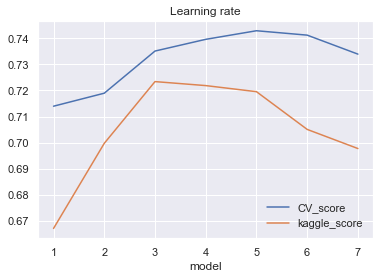

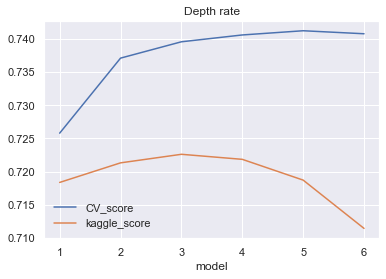

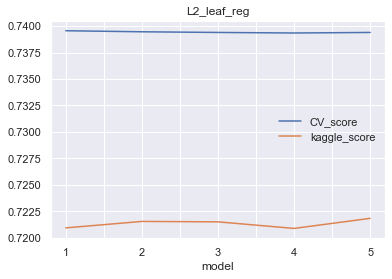

In [37]:
ax1 = df_lrate.plot(x='model', y=['CV_score', 'kaggle_score'])
ax1.set_title('Learning rate')
ax2 = df_depth.plot(x='model', y=['CV_score', 'kaggle_score'])
ax2.set_title('Depth rate')
ax3 = df_l2.plot(x='model', y=['CV_score', 'kaggle_score'])
ax3.set_title('L2_leaf_reg');

### Выводы по пункту 0:
- переобучение присутвует только при варьировании __Learning rate__, и при том довольно слабое
- изменение параметра __Depth rate__ практически не оказывает влияние на качество модели
- параметр __L2_leaf_reg__ в целом не влияет на качестов модели, что хорошо видно из показателя CV, который остается почти неизменным

## 1) GridSearchCV, RandomizedSearchCV
---
### GridSearch

In [39]:
model = CatBoostClassifier(iterations=100)

grid = {
    'learning_rate': [0.1, 0.3, 0.7],
    'depth':[3, 5, 7, 10],
    'l2_leaf_reg': [1, 3, 5, 7, 9]
}
grid_search_results = model.grid_search(grid, train_data, train_target, shuffle=False, verbose=0, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.5934216	test: 0.5931572	best: 0.5931572 (0)	total: 24.5ms	remaining: 2.42s
1:	learn: 0.5176979	test: 0.5170466	best: 0.5170466 (1)	total: 57.2ms	remaining: 2.8s
2:	learn: 0.4575646	test: 0.4565440	best: 0.4565440 (2)	total: 99.9ms	remaining: 3.23s
3:	learn: 0.4124886	test: 0.4112260	best: 0.4112260 (3)	total: 147ms	remaining: 3.52s
4:	learn: 0.3783585	test: 0.3768116	best: 0.3768116 (4)	total: 192ms	remaining: 3.64s
5:	learn: 0.3532753	test: 0.3515901	best: 0.3515901 (5)	total: 223ms	remaining: 3.49s
6:	learn: 0.3340995	test: 0.3322271	best: 0.3322271 (6)	total: 266ms	remaining: 3.54s
7:	learn: 0.3181073	test: 0.3160391	best: 0.3160391 (7)	total: 294ms	remaining: 3.38s
8:	learn: 0.3061299	test: 0.3039362	best: 0.3039362 (8)	total: 317ms	remaining: 3.2s
9:	learn: 0.2966998	test: 0.2944190	best: 0.2944190 (9)	total: 338ms	remaining: 3.04s
10:	learn: 0.2903418	test: 0.2879269	best: 0.2879269 (10)	total: 361ms	remaining: 2.92s
11:	learn: 0.2847516	test: 0.2822408	best: 0.282240

95:	learn: 0.2522199	test: 0.2489136	best: 0.2489136 (95)	total: 2.67s	remaining: 111ms
96:	learn: 0.2522043	test: 0.2489095	best: 0.2489095 (96)	total: 2.73s	remaining: 84.3ms
97:	learn: 0.2521842	test: 0.2488938	best: 0.2488938 (97)	total: 2.77s	remaining: 56.5ms
98:	learn: 0.2521537	test: 0.2488663	best: 0.2488663 (98)	total: 2.81s	remaining: 28.3ms
99:	learn: 0.2521148	test: 0.2488255	best: 0.2488255 (99)	total: 2.84s	remaining: 0us

bestTest = 0.2488255348
bestIteration = 99

0:	learn: 0.4422141	test: 0.4411356	best: 0.4411356 (0)	total: 33.9ms	remaining: 3.36s
1:	learn: 0.3407603	test: 0.3389229	best: 0.3389229 (1)	total: 78.3ms	remaining: 3.84s
2:	learn: 0.2951046	test: 0.2926621	best: 0.2926621 (2)	total: 125ms	remaining: 4.05s
3:	learn: 0.2778937	test: 0.2753171	best: 0.2753171 (3)	total: 172ms	remaining: 4.12s
4:	learn: 0.2684422	test: 0.2655433	best: 0.2655433 (4)	total: 204ms	remaining: 3.87s
5:	learn: 0.2627439	test: 0.2595024	best: 0.2595024 (5)	total: 241ms	remaining: 3.

93:	learn: 0.2500457	test: 0.2477451	best: 0.2477451 (93)	total: 3.72s	remaining: 237ms
94:	learn: 0.2500151	test: 0.2477243	best: 0.2477243 (94)	total: 3.75s	remaining: 197ms
95:	learn: 0.2499952	test: 0.2477414	best: 0.2477243 (94)	total: 3.77s	remaining: 157ms
96:	learn: 0.2499777	test: 0.2477474	best: 0.2477243 (94)	total: 3.8s	remaining: 117ms
97:	learn: 0.2499595	test: 0.2477378	best: 0.2477243 (94)	total: 3.82s	remaining: 77.9ms
98:	learn: 0.2499286	test: 0.2477187	best: 0.2477187 (98)	total: 3.84s	remaining: 38.7ms
99:	learn: 0.2499148	test: 0.2477129	best: 0.2477129 (99)	total: 3.85s	remaining: 0us

bestTest = 0.2477129275
bestIteration = 99

0:	learn: 0.2950131	test: 0.2927821	best: 0.2927821 (0)	total: 21.8ms	remaining: 2.16s
1:	learn: 0.2642840	test: 0.2608625	best: 0.2608625 (1)	total: 41.9ms	remaining: 2.05s
2:	learn: 0.2592268	test: 0.2556700	best: 0.2556700 (2)	total: 75.7ms	remaining: 2.45s
3:	learn: 0.2572641	test: 0.2535972	best: 0.2535972 (3)	total: 99.1ms	remaining

89:	learn: 0.2482464	test: 0.2479800	best: 0.2477879 (77)	total: 2.24s	remaining: 249ms
90:	learn: 0.2482176	test: 0.2480131	best: 0.2477879 (77)	total: 2.27s	remaining: 224ms
91:	learn: 0.2481866	test: 0.2480080	best: 0.2477879 (77)	total: 2.29s	remaining: 199ms
92:	learn: 0.2481031	test: 0.2479427	best: 0.2477879 (77)	total: 2.31s	remaining: 174ms
93:	learn: 0.2480737	test: 0.2479675	best: 0.2477879 (77)	total: 2.34s	remaining: 149ms
94:	learn: 0.2480252	test: 0.2479784	best: 0.2477879 (77)	total: 2.36s	remaining: 124ms
95:	learn: 0.2479876	test: 0.2479557	best: 0.2477879 (77)	total: 2.38s	remaining: 99.2ms
96:	learn: 0.2479522	test: 0.2479485	best: 0.2477879 (77)	total: 2.4s	remaining: 74.3ms
97:	learn: 0.2479105	test: 0.2479795	best: 0.2477879 (77)	total: 2.43s	remaining: 49.5ms
98:	learn: 0.2478836	test: 0.2479566	best: 0.2477879 (77)	total: 2.45s	remaining: 24.8ms
99:	learn: 0.2478729	test: 0.2479613	best: 0.2477879 (77)	total: 2.49s	remaining: 0us

bestTest = 0.2477878762
bestIt

82:	learn: 0.2526001	test: 0.2492599	best: 0.2492599 (82)	total: 1.95s	remaining: 400ms
83:	learn: 0.2525538	test: 0.2492024	best: 0.2492024 (83)	total: 1.98s	remaining: 376ms
84:	learn: 0.2525362	test: 0.2491819	best: 0.2491819 (84)	total: 2s	remaining: 352ms
85:	learn: 0.2525163	test: 0.2491635	best: 0.2491635 (85)	total: 2.02s	remaining: 329ms
86:	learn: 0.2524560	test: 0.2491066	best: 0.2491066 (86)	total: 2.04s	remaining: 305ms
87:	learn: 0.2524369	test: 0.2490947	best: 0.2490947 (87)	total: 2.06s	remaining: 281ms
88:	learn: 0.2524180	test: 0.2490772	best: 0.2490772 (88)	total: 2.08s	remaining: 257ms
89:	learn: 0.2524035	test: 0.2490746	best: 0.2490746 (89)	total: 2.1s	remaining: 233ms
90:	learn: 0.2523885	test: 0.2490724	best: 0.2490724 (90)	total: 2.12s	remaining: 210ms
91:	learn: 0.2523729	test: 0.2490617	best: 0.2490617 (91)	total: 2.14s	remaining: 186ms
92:	learn: 0.2523368	test: 0.2490302	best: 0.2490302 (92)	total: 2.17s	remaining: 163ms
93:	learn: 0.2522870	test: 0.2489753

77:	learn: 0.2504880	test: 0.2478403	best: 0.2478090 (71)	total: 2.61s	remaining: 737ms
78:	learn: 0.2504523	test: 0.2478020	best: 0.2478020 (78)	total: 2.67s	remaining: 709ms
79:	learn: 0.2504135	test: 0.2477700	best: 0.2477700 (79)	total: 2.71s	remaining: 678ms
80:	learn: 0.2503694	test: 0.2477568	best: 0.2477568 (80)	total: 2.75s	remaining: 644ms
81:	learn: 0.2503427	test: 0.2477518	best: 0.2477518 (81)	total: 2.77s	remaining: 608ms
82:	learn: 0.2503224	test: 0.2477363	best: 0.2477363 (82)	total: 2.8s	remaining: 573ms
83:	learn: 0.2502974	test: 0.2477173	best: 0.2477173 (83)	total: 2.82s	remaining: 538ms
84:	learn: 0.2502772	test: 0.2477223	best: 0.2477173 (83)	total: 2.85s	remaining: 504ms
85:	learn: 0.2502577	test: 0.2477222	best: 0.2477173 (83)	total: 2.88s	remaining: 469ms
86:	learn: 0.2502297	test: 0.2477065	best: 0.2477065 (86)	total: 2.91s	remaining: 435ms
87:	learn: 0.2502072	test: 0.2476980	best: 0.2476980 (87)	total: 2.94s	remaining: 401ms
88:	learn: 0.2501867	test: 0.2476

73:	learn: 0.2490081	test: 0.2481095	best: 0.2480663 (56)	total: 2.43s	remaining: 853ms
74:	learn: 0.2489366	test: 0.2481031	best: 0.2480663 (56)	total: 2.47s	remaining: 823ms
75:	learn: 0.2489006	test: 0.2481095	best: 0.2480663 (56)	total: 2.49s	remaining: 788ms
76:	learn: 0.2488713	test: 0.2481323	best: 0.2480663 (56)	total: 2.52s	remaining: 752ms
77:	learn: 0.2488442	test: 0.2481451	best: 0.2480663 (56)	total: 2.54s	remaining: 717ms
78:	learn: 0.2488194	test: 0.2481475	best: 0.2480663 (56)	total: 2.56s	remaining: 682ms
79:	learn: 0.2487769	test: 0.2481343	best: 0.2480663 (56)	total: 2.59s	remaining: 648ms
80:	learn: 0.2487453	test: 0.2481049	best: 0.2480663 (56)	total: 2.61s	remaining: 613ms
81:	learn: 0.2487123	test: 0.2481259	best: 0.2480663 (56)	total: 2.64s	remaining: 580ms
82:	learn: 0.2486830	test: 0.2481519	best: 0.2480663 (56)	total: 2.69s	remaining: 551ms
83:	learn: 0.2485950	test: 0.2481443	best: 0.2480663 (56)	total: 2.73s	remaining: 519ms
84:	learn: 0.2485525	test: 0.248

69:	learn: 0.2530986	test: 0.2496151	best: 0.2496151 (69)	total: 1.84s	remaining: 791ms
70:	learn: 0.2530603	test: 0.2495814	best: 0.2495814 (70)	total: 1.87s	remaining: 764ms
71:	learn: 0.2529947	test: 0.2495202	best: 0.2495202 (71)	total: 1.89s	remaining: 736ms
72:	learn: 0.2529766	test: 0.2495189	best: 0.2495189 (72)	total: 1.91s	remaining: 708ms
73:	learn: 0.2529303	test: 0.2494675	best: 0.2494675 (73)	total: 1.94s	remaining: 681ms
74:	learn: 0.2529024	test: 0.2494477	best: 0.2494477 (74)	total: 1.96s	remaining: 652ms
75:	learn: 0.2528743	test: 0.2494268	best: 0.2494268 (75)	total: 1.98s	remaining: 624ms
76:	learn: 0.2528572	test: 0.2494281	best: 0.2494268 (75)	total: 2.02s	remaining: 604ms
77:	learn: 0.2528326	test: 0.2494100	best: 0.2494100 (77)	total: 2.04s	remaining: 576ms
78:	learn: 0.2528086	test: 0.2493814	best: 0.2493814 (78)	total: 2.08s	remaining: 552ms
79:	learn: 0.2527691	test: 0.2493542	best: 0.2493542 (79)	total: 2.1s	remaining: 525ms
80:	learn: 0.2527498	test: 0.2493

68:	learn: 0.2508441	test: 0.2479187	best: 0.2479187 (68)	total: 1.66s	remaining: 746ms
69:	learn: 0.2508141	test: 0.2479396	best: 0.2479187 (68)	total: 1.69s	remaining: 724ms
70:	learn: 0.2507929	test: 0.2479265	best: 0.2479187 (68)	total: 1.71s	remaining: 700ms
71:	learn: 0.2507689	test: 0.2479229	best: 0.2479187 (68)	total: 1.73s	remaining: 674ms
72:	learn: 0.2507489	test: 0.2479397	best: 0.2479187 (68)	total: 1.76s	remaining: 650ms
73:	learn: 0.2507297	test: 0.2479349	best: 0.2479187 (68)	total: 1.78s	remaining: 625ms
74:	learn: 0.2506754	test: 0.2479072	best: 0.2479072 (74)	total: 1.8s	remaining: 600ms
75:	learn: 0.2506548	test: 0.2478933	best: 0.2478933 (75)	total: 1.82s	remaining: 575ms
76:	learn: 0.2506342	test: 0.2478839	best: 0.2478839 (76)	total: 1.84s	remaining: 550ms
77:	learn: 0.2506157	test: 0.2478743	best: 0.2478743 (77)	total: 1.87s	remaining: 527ms
78:	learn: 0.2506001	test: 0.2478746	best: 0.2478743 (77)	total: 1.9s	remaining: 505ms
79:	learn: 0.2505725	test: 0.24787

64:	learn: 0.2493906	test: 0.2479321	best: 0.2478178 (62)	total: 1.64s	remaining: 884ms
65:	learn: 0.2493692	test: 0.2479314	best: 0.2478178 (62)	total: 1.75s	remaining: 900ms
66:	learn: 0.2493139	test: 0.2478561	best: 0.2478178 (62)	total: 1.8s	remaining: 886ms
67:	learn: 0.2492597	test: 0.2478976	best: 0.2478178 (62)	total: 1.85s	remaining: 870ms
68:	learn: 0.2491843	test: 0.2478813	best: 0.2478178 (62)	total: 1.91s	remaining: 857ms
69:	learn: 0.2491642	test: 0.2478993	best: 0.2478178 (62)	total: 1.96s	remaining: 841ms
70:	learn: 0.2490923	test: 0.2478022	best: 0.2478022 (70)	total: 2.01s	remaining: 820ms
71:	learn: 0.2490648	test: 0.2478184	best: 0.2478022 (70)	total: 2.06s	remaining: 803ms
72:	learn: 0.2490341	test: 0.2478075	best: 0.2478022 (70)	total: 2.12s	remaining: 786ms
73:	learn: 0.2489937	test: 0.2478225	best: 0.2478022 (70)	total: 2.15s	remaining: 755ms
74:	learn: 0.2489733	test: 0.2478258	best: 0.2478022 (70)	total: 2.17s	remaining: 724ms
75:	learn: 0.2489464	test: 0.2478

62:	learn: 0.2534185	test: 0.2499386	best: 0.2499386 (62)	total: 1.86s	remaining: 1.09s
63:	learn: 0.2533664	test: 0.2498973	best: 0.2498973 (63)	total: 1.9s	remaining: 1.07s
64:	learn: 0.2532986	test: 0.2498402	best: 0.2498402 (64)	total: 1.92s	remaining: 1.03s
65:	learn: 0.2532684	test: 0.2498213	best: 0.2498213 (65)	total: 1.94s	remaining: 1s
66:	learn: 0.2532311	test: 0.2497873	best: 0.2497873 (66)	total: 1.96s	remaining: 968ms
67:	learn: 0.2532026	test: 0.2497545	best: 0.2497545 (67)	total: 1.99s	remaining: 934ms
68:	learn: 0.2530999	test: 0.2496576	best: 0.2496576 (68)	total: 2.01s	remaining: 903ms
69:	learn: 0.2530556	test: 0.2496043	best: 0.2496043 (69)	total: 2.03s	remaining: 869ms
70:	learn: 0.2529994	test: 0.2495555	best: 0.2495555 (70)	total: 2.05s	remaining: 837ms
71:	learn: 0.2529568	test: 0.2495149	best: 0.2495149 (71)	total: 2.08s	remaining: 810ms
72:	learn: 0.2529322	test: 0.2494925	best: 0.2494925 (72)	total: 2.11s	remaining: 780ms
73:	learn: 0.2529003	test: 0.2494817

61:	learn: 0.2510135	test: 0.2480988	best: 0.2480988 (61)	total: 1.49s	remaining: 913ms
62:	learn: 0.2509797	test: 0.2480882	best: 0.2480882 (62)	total: 1.53s	remaining: 898ms
63:	learn: 0.2509521	test: 0.2480980	best: 0.2480882 (62)	total: 1.55s	remaining: 874ms
64:	learn: 0.2509078	test: 0.2480775	best: 0.2480775 (64)	total: 1.58s	remaining: 849ms
65:	learn: 0.2508896	test: 0.2480604	best: 0.2480604 (65)	total: 1.6s	remaining: 824ms
66:	learn: 0.2508723	test: 0.2480629	best: 0.2480604 (65)	total: 1.62s	remaining: 800ms
67:	learn: 0.2508447	test: 0.2480571	best: 0.2480571 (67)	total: 1.64s	remaining: 773ms
68:	learn: 0.2508116	test: 0.2480287	best: 0.2480287 (68)	total: 1.66s	remaining: 748ms
69:	learn: 0.2507630	test: 0.2479829	best: 0.2479829 (69)	total: 1.68s	remaining: 722ms
70:	learn: 0.2507339	test: 0.2479627	best: 0.2479627 (70)	total: 1.72s	remaining: 704ms
71:	learn: 0.2507100	test: 0.2479576	best: 0.2479576 (71)	total: 1.75s	remaining: 679ms
72:	learn: 0.2506647	test: 0.2478

56:	learn: 0.2498725	test: 0.2477325	best: 0.2476495 (51)	total: 1.36s	remaining: 1.02s
57:	learn: 0.2498369	test: 0.2477414	best: 0.2476495 (51)	total: 1.39s	remaining: 1.01s
58:	learn: 0.2497411	test: 0.2477068	best: 0.2476495 (51)	total: 1.42s	remaining: 988ms
59:	learn: 0.2497073	test: 0.2477208	best: 0.2476495 (51)	total: 1.44s	remaining: 963ms
60:	learn: 0.2496581	test: 0.2476660	best: 0.2476495 (51)	total: 1.46s	remaining: 937ms
61:	learn: 0.2496242	test: 0.2477046	best: 0.2476495 (51)	total: 1.49s	remaining: 913ms
62:	learn: 0.2495822	test: 0.2476777	best: 0.2476495 (51)	total: 1.51s	remaining: 888ms
63:	learn: 0.2495385	test: 0.2477070	best: 0.2476495 (51)	total: 1.53s	remaining: 863ms
64:	learn: 0.2494936	test: 0.2477036	best: 0.2476495 (51)	total: 1.57s	remaining: 845ms
65:	learn: 0.2494382	test: 0.2476705	best: 0.2476495 (51)	total: 1.62s	remaining: 833ms
66:	learn: 0.2494176	test: 0.2476556	best: 0.2476495 (51)	total: 1.65s	remaining: 812ms
67:	learn: 0.2493877	test: 0.247

50:	learn: 0.2542479	test: 0.2506013	best: 0.2506013 (50)	total: 1.51s	remaining: 1.45s
51:	learn: 0.2541498	test: 0.2505005	best: 0.2505005 (51)	total: 1.56s	remaining: 1.44s
52:	learn: 0.2540658	test: 0.2504275	best: 0.2504275 (52)	total: 1.6s	remaining: 1.42s
53:	learn: 0.2540006	test: 0.2503724	best: 0.2503724 (53)	total: 1.64s	remaining: 1.4s
54:	learn: 0.2539559	test: 0.2503413	best: 0.2503413 (54)	total: 1.68s	remaining: 1.38s
55:	learn: 0.2538766	test: 0.2502465	best: 0.2502465 (55)	total: 1.72s	remaining: 1.35s
56:	learn: 0.2537889	test: 0.2501646	best: 0.2501646 (56)	total: 1.77s	remaining: 1.33s
57:	learn: 0.2537440	test: 0.2501207	best: 0.2501207 (57)	total: 1.81s	remaining: 1.31s
58:	learn: 0.2537102	test: 0.2500974	best: 0.2500974 (58)	total: 1.85s	remaining: 1.28s
59:	learn: 0.2536446	test: 0.2500401	best: 0.2500401 (59)	total: 1.88s	remaining: 1.25s
60:	learn: 0.2535438	test: 0.2499316	best: 0.2499316 (60)	total: 1.91s	remaining: 1.22s
61:	learn: 0.2534970	test: 0.24989

50:	learn: 0.2515829	test: 0.2485453	best: 0.2485453 (50)	total: 1.6s	remaining: 1.54s
51:	learn: 0.2515170	test: 0.2485112	best: 0.2485112 (51)	total: 1.65s	remaining: 1.52s
52:	learn: 0.2514629	test: 0.2484348	best: 0.2484348 (52)	total: 1.68s	remaining: 1.49s
53:	learn: 0.2514066	test: 0.2483879	best: 0.2483879 (53)	total: 1.7s	remaining: 1.45s
54:	learn: 0.2513760	test: 0.2483600	best: 0.2483600 (54)	total: 1.72s	remaining: 1.41s
55:	learn: 0.2513438	test: 0.2483575	best: 0.2483575 (55)	total: 1.75s	remaining: 1.37s
56:	learn: 0.2513161	test: 0.2483494	best: 0.2483494 (56)	total: 1.77s	remaining: 1.34s
57:	learn: 0.2512938	test: 0.2483404	best: 0.2483404 (57)	total: 1.79s	remaining: 1.3s
58:	learn: 0.2512707	test: 0.2483448	best: 0.2483404 (57)	total: 1.83s	remaining: 1.27s
59:	learn: 0.2512471	test: 0.2483426	best: 0.2483404 (57)	total: 1.85s	remaining: 1.23s
60:	learn: 0.2512225	test: 0.2483253	best: 0.2483253 (60)	total: 1.88s	remaining: 1.2s
61:	learn: 0.2511958	test: 0.2483232

43:	learn: 0.2502625	test: 0.2482650	best: 0.2482141 (36)	total: 1.11s	remaining: 1.41s
44:	learn: 0.2502294	test: 0.2482857	best: 0.2482141 (36)	total: 1.14s	remaining: 1.4s
45:	learn: 0.2501856	test: 0.2482807	best: 0.2482141 (36)	total: 1.16s	remaining: 1.37s
46:	learn: 0.2501450	test: 0.2483103	best: 0.2482141 (36)	total: 1.19s	remaining: 1.34s
47:	learn: 0.2501074	test: 0.2482805	best: 0.2482141 (36)	total: 1.21s	remaining: 1.31s
48:	learn: 0.2500571	test: 0.2482311	best: 0.2482141 (36)	total: 1.23s	remaining: 1.28s
49:	learn: 0.2500241	test: 0.2482554	best: 0.2482141 (36)	total: 1.25s	remaining: 1.25s
50:	learn: 0.2499785	test: 0.2482429	best: 0.2482141 (36)	total: 1.27s	remaining: 1.22s
51:	learn: 0.2499378	test: 0.2482774	best: 0.2482141 (36)	total: 1.29s	remaining: 1.19s
52:	learn: 0.2499095	test: 0.2483018	best: 0.2482141 (36)	total: 1.32s	remaining: 1.17s
53:	learn: 0.2498827	test: 0.2483066	best: 0.2482141 (36)	total: 1.35s	remaining: 1.15s
54:	learn: 0.2498215	test: 0.2482

38:	learn: 0.2536931	test: 0.2504510	best: 0.2504510 (38)	total: 1.49s	remaining: 2.34s
39:	learn: 0.2536150	test: 0.2503837	best: 0.2503837 (39)	total: 1.52s	remaining: 2.29s
40:	learn: 0.2535010	test: 0.2502798	best: 0.2502798 (40)	total: 1.55s	remaining: 2.23s
41:	learn: 0.2534233	test: 0.2501951	best: 0.2501951 (41)	total: 1.58s	remaining: 2.18s
42:	learn: 0.2533270	test: 0.2500972	best: 0.2500972 (42)	total: 1.6s	remaining: 2.12s
43:	learn: 0.2532439	test: 0.2500232	best: 0.2500232 (43)	total: 1.63s	remaining: 2.08s
44:	learn: 0.2531679	test: 0.2499675	best: 0.2499675 (44)	total: 1.67s	remaining: 2.04s
45:	learn: 0.2530742	test: 0.2498638	best: 0.2498638 (45)	total: 1.72s	remaining: 2.01s
46:	learn: 0.2529587	test: 0.2497571	best: 0.2497571 (46)	total: 1.75s	remaining: 1.97s
47:	learn: 0.2528557	test: 0.2496600	best: 0.2496600 (47)	total: 1.78s	remaining: 1.93s
48:	learn: 0.2527900	test: 0.2496177	best: 0.2496177 (48)	total: 1.81s	remaining: 1.88s
49:	learn: 0.2526979	test: 0.2495

33:	learn: 0.2509196	test: 0.2484463	best: 0.2484306 (32)	total: 1.19s	remaining: 2.32s
34:	learn: 0.2508770	test: 0.2484459	best: 0.2484306 (32)	total: 1.22s	remaining: 2.27s
35:	learn: 0.2508002	test: 0.2484003	best: 0.2484003 (35)	total: 1.25s	remaining: 2.23s
36:	learn: 0.2507553	test: 0.2484034	best: 0.2484003 (35)	total: 1.3s	remaining: 2.22s
37:	learn: 0.2506705	test: 0.2483706	best: 0.2483706 (37)	total: 1.34s	remaining: 2.18s
38:	learn: 0.2505370	test: 0.2482255	best: 0.2482255 (38)	total: 1.37s	remaining: 2.14s
39:	learn: 0.2504591	test: 0.2482155	best: 0.2482155 (39)	total: 1.4s	remaining: 2.1s
40:	learn: 0.2503815	test: 0.2481487	best: 0.2481487 (40)	total: 1.44s	remaining: 2.07s
41:	learn: 0.2502558	test: 0.2480969	best: 0.2480969 (41)	total: 1.47s	remaining: 2.03s
42:	learn: 0.2501690	test: 0.2480320	best: 0.2480320 (42)	total: 1.5s	remaining: 1.98s
43:	learn: 0.2500986	test: 0.2480108	best: 0.2480108 (43)	total: 1.53s	remaining: 1.95s
44:	learn: 0.2500104	test: 0.2479540

30:	learn: 0.2496417	test: 0.2488234	best: 0.2488144 (26)	total: 1.08s	remaining: 2.4s
31:	learn: 0.2495297	test: 0.2488405	best: 0.2488144 (26)	total: 1.11s	remaining: 2.37s
32:	learn: 0.2494392	test: 0.2488358	best: 0.2488144 (26)	total: 1.16s	remaining: 2.35s
33:	learn: 0.2493311	test: 0.2489410	best: 0.2488144 (26)	total: 1.2s	remaining: 2.32s
34:	learn: 0.2492118	test: 0.2489290	best: 0.2488144 (26)	total: 1.23s	remaining: 2.28s
35:	learn: 0.2490705	test: 0.2488675	best: 0.2488144 (26)	total: 1.26s	remaining: 2.24s
36:	learn: 0.2489587	test: 0.2489022	best: 0.2488144 (26)	total: 1.29s	remaining: 2.2s
37:	learn: 0.2488402	test: 0.2489468	best: 0.2488144 (26)	total: 1.33s	remaining: 2.17s
38:	learn: 0.2485757	test: 0.2487646	best: 0.2487646 (38)	total: 1.35s	remaining: 2.12s
39:	learn: 0.2483919	test: 0.2488017	best: 0.2487646 (38)	total: 1.38s	remaining: 2.07s
40:	learn: 0.2483199	test: 0.2488622	best: 0.2487646 (38)	total: 1.41s	remaining: 2.03s
41:	learn: 0.2482212	test: 0.248802

26:	learn: 0.2562510	test: 0.2530503	best: 0.2530503 (26)	total: 863ms	remaining: 2.33s
27:	learn: 0.2558897	test: 0.2526608	best: 0.2526608 (27)	total: 904ms	remaining: 2.33s
28:	learn: 0.2555483	test: 0.2523054	best: 0.2523054 (28)	total: 933ms	remaining: 2.29s
29:	learn: 0.2552491	test: 0.2520084	best: 0.2520084 (29)	total: 960ms	remaining: 2.24s
30:	learn: 0.2549598	test: 0.2516847	best: 0.2516847 (30)	total: 985ms	remaining: 2.19s
31:	learn: 0.2547108	test: 0.2514371	best: 0.2514371 (31)	total: 1.01s	remaining: 2.15s
32:	learn: 0.2544518	test: 0.2511601	best: 0.2511601 (32)	total: 1.04s	remaining: 2.11s
33:	learn: 0.2542779	test: 0.2509740	best: 0.2509740 (33)	total: 1.07s	remaining: 2.07s
34:	learn: 0.2541093	test: 0.2508174	best: 0.2508174 (34)	total: 1.1s	remaining: 2.05s
35:	learn: 0.2539691	test: 0.2506524	best: 0.2506524 (35)	total: 1.13s	remaining: 2.01s
36:	learn: 0.2538284	test: 0.2505216	best: 0.2505216 (36)	total: 1.17s	remaining: 1.99s
37:	learn: 0.2537106	test: 0.2504

23:	learn: 0.2520208	test: 0.2490685	best: 0.2490685 (23)	total: 968ms	remaining: 3.06s
24:	learn: 0.2519195	test: 0.2490071	best: 0.2490071 (24)	total: 1.01s	remaining: 3.02s
25:	learn: 0.2518605	test: 0.2489939	best: 0.2489939 (25)	total: 1.03s	remaining: 2.95s
26:	learn: 0.2517431	test: 0.2488522	best: 0.2488522 (26)	total: 1.06s	remaining: 2.87s
27:	learn: 0.2516848	test: 0.2488411	best: 0.2488411 (27)	total: 1.09s	remaining: 2.8s
28:	learn: 0.2516268	test: 0.2488547	best: 0.2488411 (27)	total: 1.12s	remaining: 2.74s
29:	learn: 0.2515471	test: 0.2487659	best: 0.2487659 (29)	total: 1.15s	remaining: 2.68s
30:	learn: 0.2514561	test: 0.2486524	best: 0.2486524 (30)	total: 1.18s	remaining: 2.63s
31:	learn: 0.2513784	test: 0.2486364	best: 0.2486364 (31)	total: 1.21s	remaining: 2.58s
32:	learn: 0.2512892	test: 0.2485934	best: 0.2485934 (32)	total: 1.24s	remaining: 2.52s
33:	learn: 0.2512185	test: 0.2485712	best: 0.2485712 (33)	total: 1.27s	remaining: 2.47s
34:	learn: 0.2510488	test: 0.2484

17:	learn: 0.2513270	test: 0.2490844	best: 0.2490844 (17)	total: 586ms	remaining: 2.67s
18:	learn: 0.2511473	test: 0.2489992	best: 0.2489992 (18)	total: 627ms	remaining: 2.67s
19:	learn: 0.2510403	test: 0.2490183	best: 0.2489992 (18)	total: 660ms	remaining: 2.64s
20:	learn: 0.2507311	test: 0.2485956	best: 0.2485956 (20)	total: 689ms	remaining: 2.59s
21:	learn: 0.2505828	test: 0.2486377	best: 0.2485956 (20)	total: 716ms	remaining: 2.54s
22:	learn: 0.2504042	test: 0.2486650	best: 0.2485956 (20)	total: 743ms	remaining: 2.49s
23:	learn: 0.2503024	test: 0.2486598	best: 0.2485956 (20)	total: 769ms	remaining: 2.44s
24:	learn: 0.2501071	test: 0.2486967	best: 0.2485956 (20)	total: 818ms	remaining: 2.45s
25:	learn: 0.2499687	test: 0.2487321	best: 0.2485956 (20)	total: 854ms	remaining: 2.43s
26:	learn: 0.2497621	test: 0.2486382	best: 0.2485956 (20)	total: 883ms	remaining: 2.39s
27:	learn: 0.2496784	test: 0.2486961	best: 0.2485956 (20)	total: 911ms	remaining: 2.34s
28:	learn: 0.2495382	test: 0.248

14:	learn: 0.2693365	test: 0.2664985	best: 0.2664985 (14)	total: 514ms	remaining: 2.91s
15:	learn: 0.2666196	test: 0.2637230	best: 0.2637230 (15)	total: 547ms	remaining: 2.87s
16:	learn: 0.2643869	test: 0.2614291	best: 0.2614291 (16)	total: 575ms	remaining: 2.81s
17:	learn: 0.2627102	test: 0.2597547	best: 0.2597547 (17)	total: 610ms	remaining: 2.78s
18:	learn: 0.2612346	test: 0.2582044	best: 0.2582044 (18)	total: 653ms	remaining: 2.78s
19:	learn: 0.2601694	test: 0.2570822	best: 0.2570822 (19)	total: 680ms	remaining: 2.72s
20:	learn: 0.2591860	test: 0.2560307	best: 0.2560307 (20)	total: 706ms	remaining: 2.65s
21:	learn: 0.2584050	test: 0.2552333	best: 0.2552333 (21)	total: 748ms	remaining: 2.65s
22:	learn: 0.2576389	test: 0.2544268	best: 0.2544268 (22)	total: 775ms	remaining: 2.59s
23:	learn: 0.2572025	test: 0.2540010	best: 0.2540010 (23)	total: 803ms	remaining: 2.54s
24:	learn: 0.2566780	test: 0.2534521	best: 0.2534521 (24)	total: 828ms	remaining: 2.48s
25:	learn: 0.2562349	test: 0.253

7:	learn: 0.2565468	test: 0.2532275	best: 0.2532275 (7)	total: 277ms	remaining: 3.19s
8:	learn: 0.2555972	test: 0.2521464	best: 0.2521464 (8)	total: 310ms	remaining: 3.13s
9:	learn: 0.2550605	test: 0.2516794	best: 0.2516794 (9)	total: 337ms	remaining: 3.04s
10:	learn: 0.2544583	test: 0.2511526	best: 0.2511526 (10)	total: 367ms	remaining: 2.97s
11:	learn: 0.2540953	test: 0.2507974	best: 0.2507974 (11)	total: 396ms	remaining: 2.9s
12:	learn: 0.2537525	test: 0.2504217	best: 0.2504217 (12)	total: 424ms	remaining: 2.84s
13:	learn: 0.2534648	test: 0.2501952	best: 0.2501952 (13)	total: 458ms	remaining: 2.81s
14:	learn: 0.2532603	test: 0.2499715	best: 0.2499715 (14)	total: 515ms	remaining: 2.92s
15:	learn: 0.2531569	test: 0.2499230	best: 0.2499230 (15)	total: 542ms	remaining: 2.85s
16:	learn: 0.2529655	test: 0.2497597	best: 0.2497597 (16)	total: 570ms	remaining: 2.78s
17:	learn: 0.2527378	test: 0.2494961	best: 0.2494961 (17)	total: 598ms	remaining: 2.73s
18:	learn: 0.2526320	test: 0.2494180	be

3:	learn: 0.2555827	test: 0.2519133	best: 0.2519133 (3)	total: 160ms	remaining: 3.84s
4:	learn: 0.2546718	test: 0.2510343	best: 0.2510343 (4)	total: 208ms	remaining: 3.95s
5:	learn: 0.2540001	test: 0.2504973	best: 0.2504973 (5)	total: 243ms	remaining: 3.81s
6:	learn: 0.2536655	test: 0.2501754	best: 0.2501754 (6)	total: 272ms	remaining: 3.62s
7:	learn: 0.2533238	test: 0.2499689	best: 0.2499689 (7)	total: 309ms	remaining: 3.56s
8:	learn: 0.2527880	test: 0.2494645	best: 0.2494645 (8)	total: 351ms	remaining: 3.55s
9:	learn: 0.2525327	test: 0.2492706	best: 0.2492706 (9)	total: 395ms	remaining: 3.56s
10:	learn: 0.2523354	test: 0.2490337	best: 0.2490337 (10)	total: 425ms	remaining: 3.44s
11:	learn: 0.2521349	test: 0.2490414	best: 0.2490337 (10)	total: 474ms	remaining: 3.48s
12:	learn: 0.2519811	test: 0.2489455	best: 0.2489455 (12)	total: 504ms	remaining: 3.37s
13:	learn: 0.2518557	test: 0.2489609	best: 0.2489455 (12)	total: 549ms	remaining: 3.37s
14:	learn: 0.2517397	test: 0.2489530	best: 0.2

0:	learn: 0.5890123	test: 0.5886933	best: 0.5886933 (0)	total: 26.7ms	remaining: 2.64s
1:	learn: 0.5109930	test: 0.5102640	best: 0.5102640 (1)	total: 70.9ms	remaining: 3.48s
2:	learn: 0.4550085	test: 0.4539683	best: 0.4539683 (2)	total: 102ms	remaining: 3.28s
3:	learn: 0.4105633	test: 0.4092183	best: 0.4092183 (3)	total: 137ms	remaining: 3.29s
4:	learn: 0.3760880	test: 0.3744125	best: 0.3744125 (4)	total: 167ms	remaining: 3.17s
5:	learn: 0.3490107	test: 0.3470885	best: 0.3470885 (5)	total: 194ms	remaining: 3.03s
6:	learn: 0.3305825	test: 0.3284475	best: 0.3284475 (6)	total: 222ms	remaining: 2.96s
7:	learn: 0.3163440	test: 0.3140973	best: 0.3140973 (7)	total: 261ms	remaining: 3s
8:	learn: 0.3052112	test: 0.3028128	best: 0.3028128 (8)	total: 291ms	remaining: 2.94s
9:	learn: 0.2950156	test: 0.2926019	best: 0.2926019 (9)	total: 319ms	remaining: 2.87s
10:	learn: 0.2872725	test: 0.2847961	best: 0.2847961 (10)	total: 346ms	remaining: 2.8s
11:	learn: 0.2816652	test: 0.2790706	best: 0.2790706 (

95:	learn: 0.2507842	test: 0.2481877	best: 0.2481786 (94)	total: 3.12s	remaining: 130ms
96:	learn: 0.2507680	test: 0.2481903	best: 0.2481786 (94)	total: 3.16s	remaining: 97.6ms
97:	learn: 0.2507378	test: 0.2481760	best: 0.2481760 (97)	total: 3.19s	remaining: 65ms
98:	learn: 0.2507054	test: 0.2481644	best: 0.2481644 (98)	total: 3.21s	remaining: 32.5ms
99:	learn: 0.2506715	test: 0.2481559	best: 0.2481559 (99)	total: 3.24s	remaining: 0us

bestTest = 0.2481558763
bestIteration = 99

0:	learn: 0.4334875	test: 0.4322188	best: 0.4322188 (0)	total: 30.6ms	remaining: 3.03s
1:	learn: 0.3356271	test: 0.3336672	best: 0.3336672 (1)	total: 57.1ms	remaining: 2.8s
2:	learn: 0.2932947	test: 0.2907650	best: 0.2907650 (2)	total: 94.3ms	remaining: 3.05s
3:	learn: 0.2744322	test: 0.2715952	best: 0.2715952 (3)	total: 123ms	remaining: 2.96s
4:	learn: 0.2657144	test: 0.2625479	best: 0.2625479 (4)	total: 151ms	remaining: 2.88s
5:	learn: 0.2613245	test: 0.2581680	best: 0.2581680 (5)	total: 182ms	remaining: 2.84

93:	learn: 0.2472591	test: 0.2474823	best: 0.2474622 (91)	total: 3.23s	remaining: 206ms
94:	learn: 0.2471975	test: 0.2475072	best: 0.2474622 (91)	total: 3.26s	remaining: 172ms
95:	learn: 0.2471031	test: 0.2474197	best: 0.2474197 (95)	total: 3.29s	remaining: 137ms
96:	learn: 0.2470623	test: 0.2474375	best: 0.2474197 (95)	total: 3.34s	remaining: 103ms
97:	learn: 0.2470014	test: 0.2474147	best: 0.2474147 (97)	total: 3.37s	remaining: 68.8ms
98:	learn: 0.2469489	test: 0.2474099	best: 0.2474099 (98)	total: 3.4s	remaining: 34.3ms
99:	learn: 0.2468828	test: 0.2474430	best: 0.2474099 (98)	total: 3.46s	remaining: 0us

bestTest = 0.2474099407
bestIteration = 98

0:	learn: 0.2868335	test: 0.2841897	best: 0.2841897 (0)	total: 26.8ms	remaining: 2.65s
1:	learn: 0.2612496	test: 0.2577104	best: 0.2577104 (1)	total: 51.9ms	remaining: 2.54s
2:	learn: 0.2573092	test: 0.2535752	best: 0.2535752 (2)	total: 80.7ms	remaining: 2.61s
3:	learn: 0.2555832	test: 0.2519137	best: 0.2519137 (3)	total: 107ms	remaining:

93:	learn: 0.2436701	test: 0.2496129	best: 0.2484036 (46)	total: 4.44s	remaining: 283ms
94:	learn: 0.2435939	test: 0.2496200	best: 0.2484036 (46)	total: 4.48s	remaining: 236ms
95:	learn: 0.2435102	test: 0.2496542	best: 0.2484036 (46)	total: 4.51s	remaining: 188ms
96:	learn: 0.2434278	test: 0.2496420	best: 0.2484036 (46)	total: 4.55s	remaining: 141ms
97:	learn: 0.2433662	test: 0.2496321	best: 0.2484036 (46)	total: 4.6s	remaining: 93.9ms
98:	learn: 0.2432889	test: 0.2496451	best: 0.2484036 (46)	total: 4.66s	remaining: 47.1ms
99:	learn: 0.2432076	test: 0.2496091	best: 0.2484036 (46)	total: 4.74s	remaining: 0us

bestTest = 0.2484036196
bestIteration = 46

0:	learn: 0.5890150	test: 0.5886946	best: 0.5886946 (0)	total: 48.9ms	remaining: 4.84s
1:	learn: 0.5110015	test: 0.5102725	best: 0.5102725 (1)	total: 107ms	remaining: 5.23s
2:	learn: 0.4550179	test: 0.4539771	best: 0.4539771 (2)	total: 165ms	remaining: 5.34s
3:	learn: 0.4105708	test: 0.4092254	best: 0.4092254 (3)	total: 218ms	remaining: 5

88:	learn: 0.2510024	test: 0.2482988	best: 0.2482988 (88)	total: 4.08s	remaining: 504ms
89:	learn: 0.2509806	test: 0.2482996	best: 0.2482988 (88)	total: 4.12s	remaining: 458ms
90:	learn: 0.2509593	test: 0.2483017	best: 0.2482988 (88)	total: 4.15s	remaining: 410ms
91:	learn: 0.2509450	test: 0.2482979	best: 0.2482979 (91)	total: 4.19s	remaining: 364ms
92:	learn: 0.2509094	test: 0.2482659	best: 0.2482659 (92)	total: 4.23s	remaining: 318ms
93:	learn: 0.2508928	test: 0.2482571	best: 0.2482571 (93)	total: 4.27s	remaining: 273ms
94:	learn: 0.2508602	test: 0.2482358	best: 0.2482358 (94)	total: 4.34s	remaining: 229ms
95:	learn: 0.2508368	test: 0.2482173	best: 0.2482173 (95)	total: 4.39s	remaining: 183ms
96:	learn: 0.2508272	test: 0.2482117	best: 0.2482117 (96)	total: 4.43s	remaining: 137ms
97:	learn: 0.2507935	test: 0.2481857	best: 0.2481857 (97)	total: 4.48s	remaining: 91.4ms
98:	learn: 0.2507699	test: 0.2481717	best: 0.2481717 (98)	total: 4.52s	remaining: 45.7ms
99:	learn: 0.2507515	test: 0.2

85:	learn: 0.2476810	test: 0.2475822	best: 0.2475691 (83)	total: 3.12s	remaining: 508ms
86:	learn: 0.2476516	test: 0.2475742	best: 0.2475691 (83)	total: 3.15s	remaining: 471ms
87:	learn: 0.2476006	test: 0.2475997	best: 0.2475691 (83)	total: 3.18s	remaining: 434ms
88:	learn: 0.2475639	test: 0.2475961	best: 0.2475691 (83)	total: 3.21s	remaining: 397ms
89:	learn: 0.2475251	test: 0.2475929	best: 0.2475691 (83)	total: 3.24s	remaining: 360ms
90:	learn: 0.2474674	test: 0.2475967	best: 0.2475691 (83)	total: 3.26s	remaining: 323ms
91:	learn: 0.2474154	test: 0.2475881	best: 0.2475691 (83)	total: 3.29s	remaining: 286ms
92:	learn: 0.2473750	test: 0.2475921	best: 0.2475691 (83)	total: 3.32s	remaining: 250ms
93:	learn: 0.2473418	test: 0.2475933	best: 0.2475691 (83)	total: 3.36s	remaining: 215ms
94:	learn: 0.2472993	test: 0.2475667	best: 0.2475667 (94)	total: 3.39s	remaining: 178ms
95:	learn: 0.2472565	test: 0.2475462	best: 0.2475462 (95)	total: 3.42s	remaining: 142ms
96:	learn: 0.2472045	test: 0.247

81:	learn: 0.2444949	test: 0.2488665	best: 0.2479214 (33)	total: 2.66s	remaining: 584ms
82:	learn: 0.2444138	test: 0.2489174	best: 0.2479214 (33)	total: 2.71s	remaining: 554ms
83:	learn: 0.2443246	test: 0.2489292	best: 0.2479214 (33)	total: 2.74s	remaining: 522ms
84:	learn: 0.2442647	test: 0.2489221	best: 0.2479214 (33)	total: 2.77s	remaining: 489ms
85:	learn: 0.2441681	test: 0.2489588	best: 0.2479214 (33)	total: 2.8s	remaining: 456ms
86:	learn: 0.2440685	test: 0.2490767	best: 0.2479214 (33)	total: 2.83s	remaining: 422ms
87:	learn: 0.2440534	test: 0.2491005	best: 0.2479214 (33)	total: 2.85s	remaining: 389ms
88:	learn: 0.2439845	test: 0.2491168	best: 0.2479214 (33)	total: 2.9s	remaining: 358ms
89:	learn: 0.2439053	test: 0.2491487	best: 0.2479214 (33)	total: 2.95s	remaining: 328ms
90:	learn: 0.2438491	test: 0.2491749	best: 0.2479214 (33)	total: 3s	remaining: 297ms
91:	learn: 0.2438388	test: 0.2491731	best: 0.2479214 (33)	total: 3.02s	remaining: 263ms
92:	learn: 0.2437168	test: 0.2490705	

76:	learn: 0.2493533	test: 0.2483227	best: 0.2483227 (76)	total: 3.11s	remaining: 928ms
77:	learn: 0.2493145	test: 0.2483280	best: 0.2483227 (76)	total: 3.14s	remaining: 887ms
78:	learn: 0.2492656	test: 0.2483194	best: 0.2483194 (78)	total: 3.18s	remaining: 845ms
79:	learn: 0.2491975	test: 0.2482633	best: 0.2482633 (79)	total: 3.22s	remaining: 804ms
80:	learn: 0.2491265	test: 0.2482403	best: 0.2482403 (80)	total: 3.25s	remaining: 763ms
81:	learn: 0.2490763	test: 0.2482349	best: 0.2482349 (81)	total: 3.28s	remaining: 721ms
82:	learn: 0.2489983	test: 0.2481882	best: 0.2481882 (82)	total: 3.33s	remaining: 683ms
83:	learn: 0.2489575	test: 0.2481808	best: 0.2481808 (83)	total: 3.37s	remaining: 643ms
84:	learn: 0.2489127	test: 0.2481809	best: 0.2481808 (83)	total: 3.41s	remaining: 601ms
85:	learn: 0.2488767	test: 0.2481659	best: 0.2481659 (85)	total: 3.44s	remaining: 560ms
86:	learn: 0.2488406	test: 0.2481643	best: 0.2481643 (86)	total: 3.48s	remaining: 520ms
87:	learn: 0.2487919	test: 0.248

72:	learn: 0.2433801	test: 0.2487236	best: 0.2483608 (48)	total: 3.05s	remaining: 1.13s
73:	learn: 0.2433137	test: 0.2487231	best: 0.2483608 (48)	total: 3.09s	remaining: 1.08s
74:	learn: 0.2432228	test: 0.2486975	best: 0.2483608 (48)	total: 3.13s	remaining: 1.04s
75:	learn: 0.2431266	test: 0.2487107	best: 0.2483608 (48)	total: 3.16s	remaining: 998ms
76:	learn: 0.2430382	test: 0.2486839	best: 0.2483608 (48)	total: 3.19s	remaining: 954ms
77:	learn: 0.2429481	test: 0.2486702	best: 0.2483608 (48)	total: 3.24s	remaining: 914ms
78:	learn: 0.2428721	test: 0.2486922	best: 0.2483608 (48)	total: 3.31s	remaining: 880ms
79:	learn: 0.2427817	test: 0.2486795	best: 0.2483608 (48)	total: 3.35s	remaining: 837ms
80:	learn: 0.2427213	test: 0.2486898	best: 0.2483608 (48)	total: 3.38s	remaining: 794ms
81:	learn: 0.2425897	test: 0.2487250	best: 0.2483608 (48)	total: 3.42s	remaining: 751ms
82:	learn: 0.2425134	test: 0.2487009	best: 0.2483608 (48)	total: 3.46s	remaining: 708ms
83:	learn: 0.2423909	test: 0.248

67:	learn: 0.2372909	test: 0.2533166	best: 0.2492649 (13)	total: 2.76s	remaining: 1.3s
68:	learn: 0.2371595	test: 0.2534181	best: 0.2492649 (13)	total: 2.8s	remaining: 1.26s
69:	learn: 0.2369822	test: 0.2535155	best: 0.2492649 (13)	total: 2.84s	remaining: 1.22s
70:	learn: 0.2368518	test: 0.2536148	best: 0.2492649 (13)	total: 2.9s	remaining: 1.18s
71:	learn: 0.2366576	test: 0.2536766	best: 0.2492649 (13)	total: 2.94s	remaining: 1.14s
72:	learn: 0.2363636	test: 0.2538231	best: 0.2492649 (13)	total: 2.98s	remaining: 1.1s
73:	learn: 0.2361846	test: 0.2539902	best: 0.2492649 (13)	total: 3.03s	remaining: 1.06s
74:	learn: 0.2360340	test: 0.2539787	best: 0.2492649 (13)	total: 3.08s	remaining: 1.03s
75:	learn: 0.2358782	test: 0.2539161	best: 0.2492649 (13)	total: 3.12s	remaining: 986ms
76:	learn: 0.2356440	test: 0.2539899	best: 0.2492649 (13)	total: 3.17s	remaining: 948ms
77:	learn: 0.2354813	test: 0.2541114	best: 0.2492649 (13)	total: 3.23s	remaining: 911ms
78:	learn: 0.2353360	test: 0.2542552

63:	learn: 0.2499319	test: 0.2483218	best: 0.2483218 (63)	total: 3.5s	remaining: 1.97s
64:	learn: 0.2498431	test: 0.2482754	best: 0.2482754 (64)	total: 3.54s	remaining: 1.9s
65:	learn: 0.2497777	test: 0.2482229	best: 0.2482229 (65)	total: 3.57s	remaining: 1.84s
66:	learn: 0.2497262	test: 0.2482147	best: 0.2482147 (66)	total: 3.61s	remaining: 1.78s
67:	learn: 0.2496847	test: 0.2481982	best: 0.2481982 (67)	total: 3.64s	remaining: 1.71s
68:	learn: 0.2496420	test: 0.2481937	best: 0.2481937 (68)	total: 3.68s	remaining: 1.65s
69:	learn: 0.2495975	test: 0.2481657	best: 0.2481657 (69)	total: 3.73s	remaining: 1.6s
70:	learn: 0.2495594	test: 0.2481563	best: 0.2481563 (70)	total: 3.77s	remaining: 1.54s
71:	learn: 0.2495125	test: 0.2481499	best: 0.2481499 (71)	total: 3.81s	remaining: 1.48s
72:	learn: 0.2494789	test: 0.2481418	best: 0.2481418 (72)	total: 3.85s	remaining: 1.42s
73:	learn: 0.2494232	test: 0.2481181	best: 0.2481181 (73)	total: 3.88s	remaining: 1.36s
74:	learn: 0.2493762	test: 0.248094

62:	learn: 0.2451583	test: 0.2484058	best: 0.2482723 (44)	total: 2.64s	remaining: 1.55s
63:	learn: 0.2450590	test: 0.2484318	best: 0.2482723 (44)	total: 2.68s	remaining: 1.51s
64:	learn: 0.2449933	test: 0.2484429	best: 0.2482723 (44)	total: 2.71s	remaining: 1.46s
65:	learn: 0.2448992	test: 0.2484508	best: 0.2482723 (44)	total: 2.75s	remaining: 1.42s
66:	learn: 0.2447771	test: 0.2484208	best: 0.2482723 (44)	total: 2.78s	remaining: 1.37s
67:	learn: 0.2446971	test: 0.2484157	best: 0.2482723 (44)	total: 2.82s	remaining: 1.32s
68:	learn: 0.2445896	test: 0.2484693	best: 0.2482723 (44)	total: 2.88s	remaining: 1.29s
69:	learn: 0.2444938	test: 0.2484913	best: 0.2482723 (44)	total: 2.92s	remaining: 1.25s
70:	learn: 0.2443803	test: 0.2484161	best: 0.2482723 (44)	total: 2.96s	remaining: 1.21s
71:	learn: 0.2442727	test: 0.2484708	best: 0.2482723 (44)	total: 2.99s	remaining: 1.16s
72:	learn: 0.2441824	test: 0.2484782	best: 0.2482723 (44)	total: 3.02s	remaining: 1.12s
73:	learn: 0.2440867	test: 0.248

56:	learn: 0.2406581	test: 0.2524984	best: 0.2494062 (10)	total: 2.44s	remaining: 1.84s
57:	learn: 0.2404657	test: 0.2525940	best: 0.2494062 (10)	total: 2.49s	remaining: 1.8s
58:	learn: 0.2402346	test: 0.2525900	best: 0.2494062 (10)	total: 2.53s	remaining: 1.76s
59:	learn: 0.2400719	test: 0.2526273	best: 0.2494062 (10)	total: 2.57s	remaining: 1.72s
60:	learn: 0.2399111	test: 0.2527229	best: 0.2494062 (10)	total: 2.61s	remaining: 1.67s
61:	learn: 0.2397097	test: 0.2527012	best: 0.2494062 (10)	total: 2.65s	remaining: 1.62s
62:	learn: 0.2395108	test: 0.2528531	best: 0.2494062 (10)	total: 2.7s	remaining: 1.58s
63:	learn: 0.2393666	test: 0.2529031	best: 0.2494062 (10)	total: 2.74s	remaining: 1.54s
64:	learn: 0.2392262	test: 0.2529286	best: 0.2494062 (10)	total: 2.77s	remaining: 1.49s
65:	learn: 0.2390599	test: 0.2529816	best: 0.2494062 (10)	total: 2.81s	remaining: 1.45s
66:	learn: 0.2388261	test: 0.2530023	best: 0.2494062 (10)	total: 2.84s	remaining: 1.4s
67:	learn: 0.2388141	test: 0.253005

54:	learn: 0.2507054	test: 0.2484891	best: 0.2484891 (54)	total: 3.17s	remaining: 2.6s
55:	learn: 0.2506421	test: 0.2484595	best: 0.2484595 (55)	total: 3.23s	remaining: 2.54s
56:	learn: 0.2505884	test: 0.2484454	best: 0.2484454 (56)	total: 3.27s	remaining: 2.47s
57:	learn: 0.2505391	test: 0.2484240	best: 0.2484240 (57)	total: 3.31s	remaining: 2.4s
58:	learn: 0.2504552	test: 0.2483647	best: 0.2483647 (58)	total: 3.34s	remaining: 2.32s
59:	learn: 0.2503816	test: 0.2483256	best: 0.2483256 (59)	total: 3.39s	remaining: 2.26s
60:	learn: 0.2503273	test: 0.2482954	best: 0.2482954 (60)	total: 3.43s	remaining: 2.19s
61:	learn: 0.2502505	test: 0.2482469	best: 0.2482469 (61)	total: 3.47s	remaining: 2.13s
62:	learn: 0.2502006	test: 0.2482335	best: 0.2482335 (62)	total: 3.51s	remaining: 2.06s
63:	learn: 0.2501520	test: 0.2482073	best: 0.2482073 (63)	total: 3.54s	remaining: 1.99s
64:	learn: 0.2500895	test: 0.2481857	best: 0.2481857 (64)	total: 3.59s	remaining: 1.93s
65:	learn: 0.2500348	test: 0.24815

48:	learn: 0.2470862	test: 0.2482690	best: 0.2482392 (45)	total: 2.25s	remaining: 2.34s
49:	learn: 0.2469394	test: 0.2482134	best: 0.2482134 (49)	total: 2.3s	remaining: 2.3s
50:	learn: 0.2467869	test: 0.2482023	best: 0.2482023 (50)	total: 2.33s	remaining: 2.24s
51:	learn: 0.2466648	test: 0.2481882	best: 0.2481882 (51)	total: 2.38s	remaining: 2.19s
52:	learn: 0.2465497	test: 0.2482129	best: 0.2481882 (51)	total: 2.42s	remaining: 2.15s
53:	learn: 0.2463934	test: 0.2481418	best: 0.2481418 (53)	total: 2.48s	remaining: 2.12s
54:	learn: 0.2463236	test: 0.2481366	best: 0.2481366 (54)	total: 2.52s	remaining: 2.07s
55:	learn: 0.2461849	test: 0.2482041	best: 0.2481366 (54)	total: 2.56s	remaining: 2.01s
56:	learn: 0.2460177	test: 0.2481925	best: 0.2481366 (54)	total: 2.61s	remaining: 1.97s
57:	learn: 0.2458779	test: 0.2481707	best: 0.2481366 (54)	total: 2.66s	remaining: 1.93s
58:	learn: 0.2457918	test: 0.2481651	best: 0.2481366 (54)	total: 2.73s	remaining: 1.9s
59:	learn: 0.2457103	test: 0.248186

44:	learn: 0.2431829	test: 0.2508226	best: 0.2491348 (22)	total: 2.15s	remaining: 2.63s
45:	learn: 0.2429599	test: 0.2509578	best: 0.2491348 (22)	total: 2.19s	remaining: 2.57s
46:	learn: 0.2426869	test: 0.2509987	best: 0.2491348 (22)	total: 2.23s	remaining: 2.51s
47:	learn: 0.2424715	test: 0.2511702	best: 0.2491348 (22)	total: 2.26s	remaining: 2.45s
48:	learn: 0.2422815	test: 0.2512924	best: 0.2491348 (22)	total: 2.3s	remaining: 2.39s
49:	learn: 0.2421423	test: 0.2512870	best: 0.2491348 (22)	total: 2.34s	remaining: 2.34s
50:	learn: 0.2418769	test: 0.2515314	best: 0.2491348 (22)	total: 2.41s	remaining: 2.31s
51:	learn: 0.2417649	test: 0.2515739	best: 0.2491348 (22)	total: 2.47s	remaining: 2.28s
52:	learn: 0.2415927	test: 0.2516274	best: 0.2491348 (22)	total: 2.51s	remaining: 2.23s
53:	learn: 0.2414576	test: 0.2516812	best: 0.2491348 (22)	total: 2.56s	remaining: 2.18s
54:	learn: 0.2412735	test: 0.2517978	best: 0.2491348 (22)	total: 2.61s	remaining: 2.13s
55:	learn: 0.2411875	test: 0.2518

41:	learn: 0.2517593	test: 0.2493249	best: 0.2493249 (41)	total: 1.67s	remaining: 2.31s
42:	learn: 0.2516451	test: 0.2492447	best: 0.2492447 (42)	total: 1.72s	remaining: 2.28s
43:	learn: 0.2515527	test: 0.2491777	best: 0.2491777 (43)	total: 1.76s	remaining: 2.24s
44:	learn: 0.2514531	test: 0.2490917	best: 0.2490917 (44)	total: 1.79s	remaining: 2.19s
45:	learn: 0.2513292	test: 0.2489747	best: 0.2489747 (45)	total: 1.83s	remaining: 2.15s
46:	learn: 0.2512289	test: 0.2488959	best: 0.2488959 (46)	total: 1.86s	remaining: 2.1s
47:	learn: 0.2511291	test: 0.2488085	best: 0.2488085 (47)	total: 1.91s	remaining: 2.07s
48:	learn: 0.2510769	test: 0.2487936	best: 0.2487936 (48)	total: 1.95s	remaining: 2.03s
49:	learn: 0.2509982	test: 0.2487698	best: 0.2487698 (49)	total: 1.98s	remaining: 1.98s
50:	learn: 0.2509115	test: 0.2487222	best: 0.2487222 (50)	total: 2.02s	remaining: 1.94s
51:	learn: 0.2508582	test: 0.2487266	best: 0.2487222 (50)	total: 2.06s	remaining: 1.9s
52:	learn: 0.2507806	test: 0.24866

37:	learn: 0.2486320	test: 0.2480600	best: 0.2480571 (36)	total: 2.55s	remaining: 4.17s
38:	learn: 0.2484984	test: 0.2480541	best: 0.2480541 (38)	total: 2.62s	remaining: 4.09s
39:	learn: 0.2483897	test: 0.2480091	best: 0.2480091 (39)	total: 2.68s	remaining: 4.01s
40:	learn: 0.2482612	test: 0.2480041	best: 0.2480041 (40)	total: 2.73s	remaining: 3.93s
41:	learn: 0.2481493	test: 0.2480560	best: 0.2480041 (40)	total: 2.79s	remaining: 3.85s
42:	learn: 0.2480094	test: 0.2480543	best: 0.2480041 (40)	total: 2.84s	remaining: 3.77s
43:	learn: 0.2478749	test: 0.2480304	best: 0.2480041 (40)	total: 2.88s	remaining: 3.67s
44:	learn: 0.2478164	test: 0.2480622	best: 0.2480041 (40)	total: 2.93s	remaining: 3.58s
45:	learn: 0.2476897	test: 0.2480714	best: 0.2480041 (40)	total: 2.98s	remaining: 3.5s
46:	learn: 0.2475066	test: 0.2480291	best: 0.2480041 (40)	total: 3.05s	remaining: 3.44s
47:	learn: 0.2473723	test: 0.2479518	best: 0.2479518 (47)	total: 3.08s	remaining: 3.34s
48:	learn: 0.2472727	test: 0.2479

31:	learn: 0.2456319	test: 0.2495638	best: 0.2490826 (19)	total: 1.5s	remaining: 3.19s
32:	learn: 0.2455077	test: 0.2496057	best: 0.2490826 (19)	total: 1.56s	remaining: 3.17s
33:	learn: 0.2453335	test: 0.2495274	best: 0.2490826 (19)	total: 1.6s	remaining: 3.12s
34:	learn: 0.2451704	test: 0.2495557	best: 0.2490826 (19)	total: 1.65s	remaining: 3.07s
35:	learn: 0.2449473	test: 0.2496154	best: 0.2490826 (19)	total: 1.72s	remaining: 3.05s
36:	learn: 0.2447706	test: 0.2496592	best: 0.2490826 (19)	total: 1.78s	remaining: 3.04s
37:	learn: 0.2445393	test: 0.2497519	best: 0.2490826 (19)	total: 1.83s	remaining: 2.99s
38:	learn: 0.2443918	test: 0.2498062	best: 0.2490826 (19)	total: 1.88s	remaining: 2.94s
39:	learn: 0.2443122	test: 0.2498815	best: 0.2490826 (19)	total: 1.93s	remaining: 2.89s
40:	learn: 0.2441270	test: 0.2499227	best: 0.2490826 (19)	total: 1.99s	remaining: 2.87s
41:	learn: 0.2438563	test: 0.2499795	best: 0.2490826 (19)	total: 2.05s	remaining: 2.83s
42:	learn: 0.2436238	test: 0.25006

26:	learn: 0.2546936	test: 0.2518418	best: 0.2518418 (26)	total: 1.72s	remaining: 4.65s
27:	learn: 0.2543954	test: 0.2515663	best: 0.2515663 (27)	total: 1.79s	remaining: 4.62s
28:	learn: 0.2541148	test: 0.2512769	best: 0.2512769 (28)	total: 1.88s	remaining: 4.6s
29:	learn: 0.2537822	test: 0.2509795	best: 0.2509795 (29)	total: 1.96s	remaining: 4.57s
30:	learn: 0.2535584	test: 0.2507543	best: 0.2507543 (30)	total: 2.02s	remaining: 4.5s
31:	learn: 0.2533269	test: 0.2505748	best: 0.2505748 (31)	total: 2.06s	remaining: 4.39s
32:	learn: 0.2531235	test: 0.2503695	best: 0.2503695 (32)	total: 2.11s	remaining: 4.29s
33:	learn: 0.2529334	test: 0.2502139	best: 0.2502139 (33)	total: 2.17s	remaining: 4.21s
34:	learn: 0.2527368	test: 0.2500370	best: 0.2500370 (34)	total: 2.24s	remaining: 4.15s
35:	learn: 0.2525906	test: 0.2499198	best: 0.2499198 (35)	total: 2.28s	remaining: 4.05s
36:	learn: 0.2524168	test: 0.2497750	best: 0.2497750 (36)	total: 2.32s	remaining: 3.95s
37:	learn: 0.2522833	test: 0.24966

21:	learn: 0.2507229	test: 0.2486151	best: 0.2486151 (21)	total: 1.07s	remaining: 3.8s
22:	learn: 0.2505810	test: 0.2485462	best: 0.2485462 (22)	total: 1.11s	remaining: 3.72s
23:	learn: 0.2504248	test: 0.2485745	best: 0.2485462 (22)	total: 1.15s	remaining: 3.64s
24:	learn: 0.2503146	test: 0.2485861	best: 0.2485462 (22)	total: 1.19s	remaining: 3.56s
25:	learn: 0.2501310	test: 0.2485420	best: 0.2485420 (25)	total: 1.25s	remaining: 3.56s
26:	learn: 0.2499497	test: 0.2484784	best: 0.2484784 (26)	total: 1.31s	remaining: 3.53s
27:	learn: 0.2498427	test: 0.2485118	best: 0.2484784 (26)	total: 1.35s	remaining: 3.47s
28:	learn: 0.2497694	test: 0.2485144	best: 0.2484784 (26)	total: 1.38s	remaining: 3.39s
29:	learn: 0.2496032	test: 0.2483984	best: 0.2483984 (29)	total: 1.42s	remaining: 3.31s
30:	learn: 0.2494999	test: 0.2484079	best: 0.2483984 (29)	total: 1.45s	remaining: 3.23s
31:	learn: 0.2493981	test: 0.2484118	best: 0.2483984 (29)	total: 1.49s	remaining: 3.16s
32:	learn: 0.2493131	test: 0.2483

17:	learn: 0.2490429	test: 0.2492375	best: 0.2491529 (14)	total: 696ms	remaining: 3.17s
18:	learn: 0.2487701	test: 0.2493139	best: 0.2491529 (14)	total: 744ms	remaining: 3.17s
19:	learn: 0.2483910	test: 0.2493017	best: 0.2491529 (14)	total: 780ms	remaining: 3.12s
20:	learn: 0.2481931	test: 0.2493385	best: 0.2491529 (14)	total: 813ms	remaining: 3.06s
21:	learn: 0.2479552	test: 0.2494039	best: 0.2491529 (14)	total: 849ms	remaining: 3.01s
22:	learn: 0.2476777	test: 0.2495178	best: 0.2491529 (14)	total: 884ms	remaining: 2.96s
23:	learn: 0.2474422	test: 0.2495057	best: 0.2491529 (14)	total: 934ms	remaining: 2.96s
24:	learn: 0.2471968	test: 0.2493755	best: 0.2491529 (14)	total: 968ms	remaining: 2.9s
25:	learn: 0.2470123	test: 0.2493318	best: 0.2491529 (14)	total: 1s	remaining: 2.85s
26:	learn: 0.2467983	test: 0.2493795	best: 0.2491529 (14)	total: 1.04s	remaining: 2.81s
27:	learn: 0.2466039	test: 0.2493821	best: 0.2491529 (14)	total: 1.08s	remaining: 2.79s
28:	learn: 0.2464514	test: 0.2494276

11:	learn: 0.2766378	test: 0.2748930	best: 0.2748930 (11)	total: 1.55s	remaining: 11.4s
12:	learn: 0.2718258	test: 0.2701748	best: 0.2701748 (12)	total: 1.69s	remaining: 11.3s
13:	learn: 0.2681819	test: 0.2665988	best: 0.2665988 (13)	total: 1.78s	remaining: 11s
14:	learn: 0.2649224	test: 0.2633798	best: 0.2633798 (14)	total: 1.87s	remaining: 10.6s
15:	learn: 0.2622366	test: 0.2609014	best: 0.2609014 (15)	total: 1.95s	remaining: 10.2s
16:	learn: 0.2604299	test: 0.2591176	best: 0.2591176 (16)	total: 2.04s	remaining: 9.94s
17:	learn: 0.2587419	test: 0.2576104	best: 0.2576104 (17)	total: 2.12s	remaining: 9.64s
18:	learn: 0.2574506	test: 0.2564221	best: 0.2564221 (18)	total: 2.19s	remaining: 9.35s
19:	learn: 0.2564975	test: 0.2554419	best: 0.2554419 (19)	total: 2.25s	remaining: 8.99s
20:	learn: 0.2554142	test: 0.2544552	best: 0.2544552 (20)	total: 2.35s	remaining: 8.86s
21:	learn: 0.2545398	test: 0.2536467	best: 0.2536467 (21)	total: 2.44s	remaining: 8.67s
22:	learn: 0.2537371	test: 0.25292

5:	learn: 0.2569856	test: 0.2557914	best: 0.2557914 (5)	total: 677ms	remaining: 10.6s
6:	learn: 0.2544483	test: 0.2535185	best: 0.2535185 (6)	total: 800ms	remaining: 10.6s
7:	learn: 0.2524265	test: 0.2517441	best: 0.2517441 (7)	total: 914ms	remaining: 10.5s
8:	learn: 0.2512023	test: 0.2508993	best: 0.2508993 (8)	total: 1.01s	remaining: 10.2s
9:	learn: 0.2501933	test: 0.2504865	best: 0.2504865 (9)	total: 1.19s	remaining: 10.7s
10:	learn: 0.2494312	test: 0.2503444	best: 0.2503444 (10)	total: 1.31s	remaining: 10.6s
11:	learn: 0.2488671	test: 0.2502000	best: 0.2502000 (11)	total: 1.41s	remaining: 10.4s
12:	learn: 0.2484192	test: 0.2499981	best: 0.2499981 (12)	total: 1.49s	remaining: 9.95s
13:	learn: 0.2479125	test: 0.2499158	best: 0.2499158 (13)	total: 1.56s	remaining: 9.62s
14:	learn: 0.2473050	test: 0.2497534	best: 0.2497534 (14)	total: 1.68s	remaining: 9.54s
15:	learn: 0.2468436	test: 0.2496433	best: 0.2496433 (15)	total: 1.78s	remaining: 9.34s
16:	learn: 0.2463065	test: 0.2496709	best:

0:	learn: 0.2827508	test: 0.2804135	best: 0.2804135 (0)	total: 136ms	remaining: 13.5s
1:	learn: 0.2568189	test: 0.2552669	best: 0.2552669 (1)	total: 281ms	remaining: 13.8s
2:	learn: 0.2529305	test: 0.2524473	best: 0.2524473 (2)	total: 404ms	remaining: 13.1s
3:	learn: 0.2510726	test: 0.2518965	best: 0.2518965 (3)	total: 563ms	remaining: 13.5s
4:	learn: 0.2498087	test: 0.2520292	best: 0.2518965 (3)	total: 792ms	remaining: 15s
5:	learn: 0.2484465	test: 0.2524357	best: 0.2518965 (3)	total: 976ms	remaining: 15.3s
6:	learn: 0.2473425	test: 0.2525278	best: 0.2518965 (3)	total: 1.16s	remaining: 15.4s
7:	learn: 0.2461371	test: 0.2527081	best: 0.2518965 (3)	total: 1.28s	remaining: 14.8s
8:	learn: 0.2452886	test: 0.2526968	best: 0.2518965 (3)	total: 1.36s	remaining: 13.8s
9:	learn: 0.2447069	test: 0.2529050	best: 0.2518965 (3)	total: 1.46s	remaining: 13.1s
10:	learn: 0.2441514	test: 0.2531990	best: 0.2518965 (3)	total: 1.56s	remaining: 12.6s
11:	learn: 0.2432783	test: 0.2533930	best: 0.2518965 (3

96:	learn: 0.1932461	test: 0.2799972	best: 0.2518965 (3)	total: 10.8s	remaining: 334ms
97:	learn: 0.1928274	test: 0.2801627	best: 0.2518965 (3)	total: 10.9s	remaining: 222ms
98:	learn: 0.1921999	test: 0.2807020	best: 0.2518965 (3)	total: 11s	remaining: 111ms
99:	learn: 0.1918051	test: 0.2808430	best: 0.2518965 (3)	total: 11s	remaining: 0us

bestTest = 0.2518965462
bestIteration = 3

0:	learn: 0.5867689	test: 0.5865329	best: 0.5865329 (0)	total: 79.8ms	remaining: 7.9s
1:	learn: 0.5079356	test: 0.5071534	best: 0.5071534 (1)	total: 164ms	remaining: 8.03s
2:	learn: 0.4486471	test: 0.4476699	best: 0.4476699 (2)	total: 259ms	remaining: 8.36s
3:	learn: 0.4050292	test: 0.4039957	best: 0.4039957 (3)	total: 347ms	remaining: 8.32s
4:	learn: 0.3718610	test: 0.3707304	best: 0.3707304 (4)	total: 427ms	remaining: 8.1s
5:	learn: 0.3450077	test: 0.3436801	best: 0.3436801 (5)	total: 511ms	remaining: 8s
6:	learn: 0.3259632	test: 0.3245489	best: 0.3245489 (6)	total: 600ms	remaining: 7.96s
7:	learn: 0.3101

92:	learn: 0.2404459	test: 0.2483056	best: 0.2482871 (78)	total: 10s	remaining: 754ms
93:	learn: 0.2403368	test: 0.2483109	best: 0.2482871 (78)	total: 10.1s	remaining: 644ms
94:	learn: 0.2402428	test: 0.2482918	best: 0.2482871 (78)	total: 10.2s	remaining: 535ms
95:	learn: 0.2401113	test: 0.2483119	best: 0.2482871 (78)	total: 10.2s	remaining: 427ms
96:	learn: 0.2400182	test: 0.2483032	best: 0.2482871 (78)	total: 10.3s	remaining: 319ms
97:	learn: 0.2398026	test: 0.2482841	best: 0.2482841 (97)	total: 10.4s	remaining: 213ms
98:	learn: 0.2396388	test: 0.2482674	best: 0.2482674 (98)	total: 10.6s	remaining: 107ms
99:	learn: 0.2395110	test: 0.2482757	best: 0.2482674 (98)	total: 10.7s	remaining: 0us

bestTest = 0.2482674056
bestIteration = 98

0:	learn: 0.4289862	test: 0.4280465	best: 0.4280465 (0)	total: 98.6ms	remaining: 9.76s
1:	learn: 0.3282409	test: 0.3268322	best: 0.3268322 (1)	total: 177ms	remaining: 8.66s
2:	learn: 0.2874552	test: 0.2860023	best: 0.2860023 (2)	total: 273ms	remaining: 8.

87:	learn: 0.2221653	test: 0.2526761	best: 0.2491576 (22)	total: 9.73s	remaining: 1.33s
88:	learn: 0.2217585	test: 0.2528005	best: 0.2491576 (22)	total: 9.81s	remaining: 1.21s
89:	learn: 0.2214363	test: 0.2528410	best: 0.2491576 (22)	total: 9.9s	remaining: 1.1s
90:	learn: 0.2210921	test: 0.2528530	best: 0.2491576 (22)	total: 9.97s	remaining: 987ms
91:	learn: 0.2209255	test: 0.2528436	best: 0.2491576 (22)	total: 10s	remaining: 873ms
92:	learn: 0.2206157	test: 0.2528755	best: 0.2491576 (22)	total: 10.1s	remaining: 762ms
93:	learn: 0.2204297	test: 0.2529075	best: 0.2491576 (22)	total: 10.2s	remaining: 651ms
94:	learn: 0.2201932	test: 0.2529223	best: 0.2491576 (22)	total: 10.3s	remaining: 540ms
95:	learn: 0.2200505	test: 0.2529622	best: 0.2491576 (22)	total: 10.4s	remaining: 431ms
96:	learn: 0.2199004	test: 0.2529960	best: 0.2491576 (22)	total: 10.4s	remaining: 322ms
97:	learn: 0.2198278	test: 0.2529984	best: 0.2491576 (22)	total: 10.5s	remaining: 214ms
98:	learn: 0.2195077	test: 0.2529765

82:	learn: 0.2024613	test: 0.2694672	best: 0.2512565 (5)	total: 10.1s	remaining: 2.07s
83:	learn: 0.2020174	test: 0.2697466	best: 0.2512565 (5)	total: 10.2s	remaining: 1.95s
84:	learn: 0.2013543	test: 0.2699727	best: 0.2512565 (5)	total: 10.3s	remaining: 1.82s
85:	learn: 0.2007846	test: 0.2702424	best: 0.2512565 (5)	total: 10.4s	remaining: 1.69s
86:	learn: 0.2002533	test: 0.2706232	best: 0.2512565 (5)	total: 10.5s	remaining: 1.57s
87:	learn: 0.1995471	test: 0.2708760	best: 0.2512565 (5)	total: 10.6s	remaining: 1.44s
88:	learn: 0.1991524	test: 0.2710505	best: 0.2512565 (5)	total: 10.7s	remaining: 1.32s
89:	learn: 0.1988195	test: 0.2710835	best: 0.2512565 (5)	total: 10.7s	remaining: 1.19s
90:	learn: 0.1982825	test: 0.2713572	best: 0.2512565 (5)	total: 10.8s	remaining: 1.07s
91:	learn: 0.1979713	test: 0.2714973	best: 0.2512565 (5)	total: 10.9s	remaining: 949ms
92:	learn: 0.1974991	test: 0.2714754	best: 0.2512565 (5)	total: 11s	remaining: 828ms
93:	learn: 0.1970591	test: 0.2718400	best: 0.

77:	learn: 0.2429479	test: 0.2482677	best: 0.2481998 (73)	total: 8.11s	remaining: 2.29s
78:	learn: 0.2428554	test: 0.2482820	best: 0.2481998 (73)	total: 8.26s	remaining: 2.2s
79:	learn: 0.2427362	test: 0.2482841	best: 0.2481998 (73)	total: 8.43s	remaining: 2.11s
80:	learn: 0.2425847	test: 0.2482803	best: 0.2481998 (73)	total: 8.59s	remaining: 2.02s
81:	learn: 0.2423933	test: 0.2482896	best: 0.2481998 (73)	total: 8.76s	remaining: 1.92s
82:	learn: 0.2422912	test: 0.2483003	best: 0.2481998 (73)	total: 8.94s	remaining: 1.83s
83:	learn: 0.2422008	test: 0.2482894	best: 0.2481998 (73)	total: 9.14s	remaining: 1.74s
84:	learn: 0.2420839	test: 0.2482982	best: 0.2481998 (73)	total: 9.29s	remaining: 1.64s
85:	learn: 0.2419717	test: 0.2483212	best: 0.2481998 (73)	total: 9.5s	remaining: 1.55s
86:	learn: 0.2418953	test: 0.2483277	best: 0.2481998 (73)	total: 9.67s	remaining: 1.44s
87:	learn: 0.2417096	test: 0.2483402	best: 0.2481998 (73)	total: 9.8s	remaining: 1.34s
88:	learn: 0.2415985	test: 0.248324

71:	learn: 0.2296894	test: 0.2506020	best: 0.2490141 (23)	total: 6.84s	remaining: 2.66s
72:	learn: 0.2294747	test: 0.2506004	best: 0.2490141 (23)	total: 6.92s	remaining: 2.56s
73:	learn: 0.2292056	test: 0.2505584	best: 0.2490141 (23)	total: 7s	remaining: 2.46s
74:	learn: 0.2288232	test: 0.2506366	best: 0.2490141 (23)	total: 7.08s	remaining: 2.36s
75:	learn: 0.2286601	test: 0.2506476	best: 0.2490141 (23)	total: 7.16s	remaining: 2.26s
76:	learn: 0.2283796	test: 0.2507113	best: 0.2490141 (23)	total: 7.24s	remaining: 2.16s
77:	learn: 0.2281904	test: 0.2507269	best: 0.2490141 (23)	total: 7.32s	remaining: 2.06s
78:	learn: 0.2279927	test: 0.2508065	best: 0.2490141 (23)	total: 7.4s	remaining: 1.97s
79:	learn: 0.2276717	test: 0.2508861	best: 0.2490141 (23)	total: 7.48s	remaining: 1.87s
80:	learn: 0.2274614	test: 0.2509778	best: 0.2490141 (23)	total: 7.56s	remaining: 1.77s
81:	learn: 0.2272973	test: 0.2509663	best: 0.2490141 (23)	total: 7.64s	remaining: 1.68s
82:	learn: 0.2270490	test: 0.2509312

65:	learn: 0.2135659	test: 0.2633287	best: 0.2515146 (8)	total: 6.65s	remaining: 3.43s
66:	learn: 0.2128652	test: 0.2636165	best: 0.2515146 (8)	total: 6.75s	remaining: 3.32s
67:	learn: 0.2124163	test: 0.2636874	best: 0.2515146 (8)	total: 6.84s	remaining: 3.22s
68:	learn: 0.2118319	test: 0.2637911	best: 0.2515146 (8)	total: 6.97s	remaining: 3.13s
69:	learn: 0.2112987	test: 0.2639615	best: 0.2515146 (8)	total: 7.06s	remaining: 3.02s
70:	learn: 0.2106665	test: 0.2642506	best: 0.2515146 (8)	total: 7.14s	remaining: 2.92s
71:	learn: 0.2103371	test: 0.2643957	best: 0.2515146 (8)	total: 7.23s	remaining: 2.81s
72:	learn: 0.2096341	test: 0.2647078	best: 0.2515146 (8)	total: 7.31s	remaining: 2.7s
73:	learn: 0.2092022	test: 0.2651006	best: 0.2515146 (8)	total: 7.39s	remaining: 2.6s
74:	learn: 0.2085874	test: 0.2656006	best: 0.2515146 (8)	total: 7.47s	remaining: 2.49s
75:	learn: 0.2082829	test: 0.2656870	best: 0.2515146 (8)	total: 7.55s	remaining: 2.38s
76:	learn: 0.2076546	test: 0.2659339	best: 0.

60:	learn: 0.2455631	test: 0.2481968	best: 0.2481831 (58)	total: 11.2s	remaining: 7.16s
61:	learn: 0.2454383	test: 0.2482179	best: 0.2481831 (58)	total: 11.3s	remaining: 6.93s
62:	learn: 0.2452893	test: 0.2482108	best: 0.2481831 (58)	total: 11.4s	remaining: 6.69s
63:	learn: 0.2451522	test: 0.2482026	best: 0.2481831 (58)	total: 11.5s	remaining: 6.45s
64:	learn: 0.2449661	test: 0.2481696	best: 0.2481696 (64)	total: 11.6s	remaining: 6.22s
65:	learn: 0.2448455	test: 0.2481594	best: 0.2481594 (65)	total: 11.7s	remaining: 6.03s
66:	learn: 0.2447264	test: 0.2481347	best: 0.2481347 (66)	total: 11.8s	remaining: 5.82s
67:	learn: 0.2446066	test: 0.2481585	best: 0.2481347 (66)	total: 11.9s	remaining: 5.6s
68:	learn: 0.2445191	test: 0.2481375	best: 0.2481347 (66)	total: 12s	remaining: 5.38s
69:	learn: 0.2444144	test: 0.2481191	best: 0.2481191 (69)	total: 12s	remaining: 5.16s
70:	learn: 0.2443040	test: 0.2481202	best: 0.2481191 (69)	total: 12.1s	remaining: 4.95s
71:	learn: 0.2442138	test: 0.2481202	

55:	learn: 0.2353055	test: 0.2495423	best: 0.2489308 (24)	total: 5.13s	remaining: 4.03s
56:	learn: 0.2351045	test: 0.2495472	best: 0.2489308 (24)	total: 5.35s	remaining: 4.03s
57:	learn: 0.2347529	test: 0.2495668	best: 0.2489308 (24)	total: 5.79s	remaining: 4.19s
58:	learn: 0.2345169	test: 0.2495713	best: 0.2489308 (24)	total: 6.15s	remaining: 4.27s
59:	learn: 0.2342386	test: 0.2495973	best: 0.2489308 (24)	total: 6.27s	remaining: 4.18s
60:	learn: 0.2339629	test: 0.2496563	best: 0.2489308 (24)	total: 6.38s	remaining: 4.08s
61:	learn: 0.2337352	test: 0.2496948	best: 0.2489308 (24)	total: 6.49s	remaining: 3.98s
62:	learn: 0.2335675	test: 0.2497325	best: 0.2489308 (24)	total: 6.59s	remaining: 3.87s
63:	learn: 0.2333313	test: 0.2497529	best: 0.2489308 (24)	total: 6.7s	remaining: 3.77s
64:	learn: 0.2330552	test: 0.2497602	best: 0.2489308 (24)	total: 6.8s	remaining: 3.66s
65:	learn: 0.2327599	test: 0.2497833	best: 0.2489308 (24)	total: 6.93s	remaining: 3.57s
66:	learn: 0.2324801	test: 0.24980

49:	learn: 0.2232714	test: 0.2589728	best: 0.2512371 (9)	total: 4.83s	remaining: 4.83s
50:	learn: 0.2223996	test: 0.2596865	best: 0.2512371 (9)	total: 5.09s	remaining: 4.89s
51:	learn: 0.2219203	test: 0.2599106	best: 0.2512371 (9)	total: 5.35s	remaining: 4.93s
52:	learn: 0.2214057	test: 0.2602181	best: 0.2512371 (9)	total: 5.53s	remaining: 4.9s
53:	learn: 0.2208258	test: 0.2604062	best: 0.2512371 (9)	total: 5.63s	remaining: 4.8s
54:	learn: 0.2204130	test: 0.2608021	best: 0.2512371 (9)	total: 5.73s	remaining: 4.69s
55:	learn: 0.2202073	test: 0.2608356	best: 0.2512371 (9)	total: 5.83s	remaining: 4.58s
56:	learn: 0.2195930	test: 0.2611479	best: 0.2512371 (9)	total: 5.91s	remaining: 4.46s
57:	learn: 0.2188609	test: 0.2614552	best: 0.2512371 (9)	total: 5.99s	remaining: 4.33s
58:	learn: 0.2183915	test: 0.2617663	best: 0.2512371 (9)	total: 6.06s	remaining: 4.21s
59:	learn: 0.2178961	test: 0.2619613	best: 0.2512371 (9)	total: 6.13s	remaining: 4.09s
60:	learn: 0.2174395	test: 0.2621604	best: 0.

43:	learn: 0.2483500	test: 0.2487760	best: 0.2487760 (43)	total: 4.27s	remaining: 5.43s
44:	learn: 0.2482357	test: 0.2487477	best: 0.2487477 (44)	total: 4.41s	remaining: 5.39s
45:	learn: 0.2480854	test: 0.2486620	best: 0.2486620 (45)	total: 4.56s	remaining: 5.35s
46:	learn: 0.2480138	test: 0.2486543	best: 0.2486543 (46)	total: 4.88s	remaining: 5.5s
47:	learn: 0.2478923	test: 0.2486415	best: 0.2486415 (47)	total: 4.98s	remaining: 5.39s
48:	learn: 0.2477746	test: 0.2486279	best: 0.2486279 (48)	total: 5.07s	remaining: 5.28s
49:	learn: 0.2476301	test: 0.2485813	best: 0.2485813 (49)	total: 5.16s	remaining: 5.16s
50:	learn: 0.2475007	test: 0.2485532	best: 0.2485532 (50)	total: 5.24s	remaining: 5.03s
51:	learn: 0.2473632	test: 0.2484911	best: 0.2484911 (51)	total: 5.32s	remaining: 4.91s
52:	learn: 0.2472115	test: 0.2484746	best: 0.2484746 (52)	total: 5.49s	remaining: 4.86s
53:	learn: 0.2470678	test: 0.2484420	best: 0.2484420 (53)	total: 5.64s	remaining: 4.81s
54:	learn: 0.2469138	test: 0.2483

39:	learn: 0.2401351	test: 0.2492280	best: 0.2487807 (21)	total: 3.78s	remaining: 5.67s
40:	learn: 0.2398153	test: 0.2492826	best: 0.2487807 (21)	total: 3.86s	remaining: 5.56s
41:	learn: 0.2395712	test: 0.2493160	best: 0.2487807 (21)	total: 3.94s	remaining: 5.44s
42:	learn: 0.2392209	test: 0.2493091	best: 0.2487807 (21)	total: 4.02s	remaining: 5.33s
43:	learn: 0.2388972	test: 0.2493640	best: 0.2487807 (21)	total: 4.1s	remaining: 5.21s
44:	learn: 0.2387396	test: 0.2494730	best: 0.2487807 (21)	total: 4.23s	remaining: 5.17s
45:	learn: 0.2385438	test: 0.2495127	best: 0.2487807 (21)	total: 4.44s	remaining: 5.22s
46:	learn: 0.2381886	test: 0.2493693	best: 0.2487807 (21)	total: 4.54s	remaining: 5.12s
47:	learn: 0.2378568	test: 0.2494788	best: 0.2487807 (21)	total: 4.62s	remaining: 5.01s
48:	learn: 0.2376074	test: 0.2494945	best: 0.2487807 (21)	total: 4.7s	remaining: 4.89s
49:	learn: 0.2373556	test: 0.2495389	best: 0.2487807 (21)	total: 4.81s	remaining: 4.81s
50:	learn: 0.2371029	test: 0.24958

35:	learn: 0.2309353	test: 0.2559225	best: 0.2505463 (10)	total: 3.53s	remaining: 6.28s
36:	learn: 0.2304183	test: 0.2560347	best: 0.2505463 (10)	total: 3.66s	remaining: 6.24s
37:	learn: 0.2297883	test: 0.2562091	best: 0.2505463 (10)	total: 3.77s	remaining: 6.15s
38:	learn: 0.2290959	test: 0.2564351	best: 0.2505463 (10)	total: 3.86s	remaining: 6.04s
39:	learn: 0.2284725	test: 0.2565489	best: 0.2505463 (10)	total: 3.95s	remaining: 5.92s
40:	learn: 0.2279285	test: 0.2567981	best: 0.2505463 (10)	total: 4.04s	remaining: 5.82s
41:	learn: 0.2273642	test: 0.2570666	best: 0.2505463 (10)	total: 4.13s	remaining: 5.7s
42:	learn: 0.2268342	test: 0.2571544	best: 0.2505463 (10)	total: 4.22s	remaining: 5.59s
43:	learn: 0.2262836	test: 0.2571537	best: 0.2505463 (10)	total: 4.32s	remaining: 5.5s
44:	learn: 0.2258721	test: 0.2572237	best: 0.2505463 (10)	total: 4.41s	remaining: 5.39s
45:	learn: 0.2254800	test: 0.2573295	best: 0.2505463 (10)	total: 4.5s	remaining: 5.29s
46:	learn: 0.2250977	test: 0.257553

28:	learn: 0.2505674	test: 0.2516818	best: 0.2516818 (28)	total: 882ms	remaining: 2.16s
29:	learn: 0.2505114	test: 0.2516704	best: 0.2516704 (29)	total: 916ms	remaining: 2.14s
30:	learn: 0.2503762	test: 0.2515827	best: 0.2515827 (30)	total: 947ms	remaining: 2.11s
31:	learn: 0.2502839	test: 0.2515334	best: 0.2515334 (31)	total: 977ms	remaining: 2.08s
32:	learn: 0.2502057	test: 0.2514583	best: 0.2514583 (32)	total: 1s	remaining: 2.04s
33:	learn: 0.2501352	test: 0.2514582	best: 0.2514582 (33)	total: 1.03s	remaining: 2.01s
34:	learn: 0.2500239	test: 0.2514258	best: 0.2514258 (34)	total: 1.06s	remaining: 1.96s
35:	learn: 0.2499740	test: 0.2514357	best: 0.2514258 (34)	total: 1.09s	remaining: 1.93s
36:	learn: 0.2499323	test: 0.2514353	best: 0.2514258 (34)	total: 1.11s	remaining: 1.9s
37:	learn: 0.2498589	test: 0.2513844	best: 0.2513844 (37)	total: 1.14s	remaining: 1.87s
38:	learn: 0.2498158	test: 0.2513665	best: 0.2513665 (38)	total: 1.18s	remaining: 1.85s
39:	learn: 0.2496995	test: 0.2512699

23:	learn: 0.2504433	test: 0.2527418	best: 0.2527418 (23)	total: 681ms	remaining: 2.15s
24:	learn: 0.2503564	test: 0.2527055	best: 0.2527055 (24)	total: 709ms	remaining: 2.13s
25:	learn: 0.2501539	test: 0.2525659	best: 0.2525659 (25)	total: 740ms	remaining: 2.1s
26:	learn: 0.2500619	test: 0.2525354	best: 0.2525354 (26)	total: 775ms	remaining: 2.1s
27:	learn: 0.2499642	test: 0.2525257	best: 0.2525257 (27)	total: 808ms	remaining: 2.08s
28:	learn: 0.2498980	test: 0.2525007	best: 0.2525007 (28)	total: 838ms	remaining: 2.05s
29:	learn: 0.2497893	test: 0.2524924	best: 0.2524924 (29)	total: 867ms	remaining: 2.02s
30:	learn: 0.2496534	test: 0.2524521	best: 0.2524521 (30)	total: 899ms	remaining: 2s
31:	learn: 0.2495728	test: 0.2524327	best: 0.2524327 (31)	total: 926ms	remaining: 1.97s
32:	learn: 0.2495052	test: 0.2523876	best: 0.2523876 (32)	total: 954ms	remaining: 1.94s
33:	learn: 0.2494177	test: 0.2523352	best: 0.2523352 (33)	total: 980ms	remaining: 1.9s
34:	learn: 0.2493460	test: 0.2523549	b

22:	learn: 0.2515112	test: 0.2515033	best: 0.2515033 (22)	total: 689ms	remaining: 2.31s
23:	learn: 0.2513842	test: 0.2514088	best: 0.2514088 (23)	total: 718ms	remaining: 2.27s
24:	learn: 0.2512907	test: 0.2514084	best: 0.2514084 (24)	total: 746ms	remaining: 2.24s
25:	learn: 0.2512008	test: 0.2513837	best: 0.2513837 (25)	total: 776ms	remaining: 2.21s
26:	learn: 0.2511096	test: 0.2513462	best: 0.2513462 (26)	total: 804ms	remaining: 2.17s
27:	learn: 0.2510163	test: 0.2513281	best: 0.2513281 (27)	total: 830ms	remaining: 2.13s
28:	learn: 0.2509609	test: 0.2513081	best: 0.2513081 (28)	total: 858ms	remaining: 2.1s
29:	learn: 0.2508820	test: 0.2513044	best: 0.2513044 (29)	total: 885ms	remaining: 2.06s
30:	learn: 0.2508055	test: 0.2513080	best: 0.2513044 (29)	total: 916ms	remaining: 2.04s
31:	learn: 0.2506757	test: 0.2512202	best: 0.2512202 (31)	total: 946ms	remaining: 2.01s
32:	learn: 0.2506162	test: 0.2512170	best: 0.2512170 (32)	total: 973ms	remaining: 1.98s
33:	learn: 0.2505458	test: 0.2511

In [40]:
grid_search_results['params']

{'depth': 5, 'l2_leaf_reg': 7, 'learning_rate': 0.3}

In [41]:
make_submission('gridSearch', CatBoostClassifier, loss_function='Logloss', eval_metric='AUC:hints=skip_train~false', metric_period=50,
                                          random_seed = 42, iterations=100, learning_rate=0.3, depth = 5, l2_leaf_reg=7)

0:	learn: 0.6642218	total: 70.9ms	remaining: 7.02s
50:	learn: 0.7449709	total: 1.3s	remaining: 1.25s
99:	learn: 0.7490701	total: 2.39s	remaining: 0us
100%|███████████████████████████████████████| 1.26M/1.26M [00:01<00:00, 780kB/s]
Successfully submitted to Home Credit Default Risk

### Public score = 0.71801

### RandomizedSearchCV

In [42]:
model = CatBoostClassifier(iterations=100)

In [43]:
param_distribution = {
    'learning_rate': stats.uniform(0, 1),
    'l2_leaf_reg': stats.bernoulli(p=0.3, loc=2),
    'depth': stats.binom(n=10, p=0.2)
}

randomized_search_results = model.randomized_search(
    param_distribution,
    train_data,
    train_target,
    n_iter=7,
    search_by_train_test_split=True,
    shuffle=False,
    plot=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.3017615	test: 0.2993703	best: 0.2993703 (0)	total: 47.7ms	remaining: 4.72s
1:	learn: 0.2658453	test: 0.2628315	best: 0.2628315 (1)	total: 72.7ms	remaining: 3.56s
2:	learn: 0.2591827	test: 0.2560671	best: 0.2560671 (2)	total: 97.5ms	remaining: 3.15s
3:	learn: 0.2563035	test: 0.2526974	best: 0.2526974 (3)	total: 123ms	remaining: 2.96s
4:	learn: 0.2547053	test: 0.2513453	best: 0.2513453 (4)	total: 151ms	remaining: 2.88s
5:	learn: 0.2539752	test: 0.2505873	best: 0.2505873 (5)	total: 179ms	remaining: 2.81s
6:	learn: 0.2536195	test: 0.2503595	best: 0.2503595 (6)	total: 205ms	remaining: 2.73s
7:	learn: 0.2533180	test: 0.2502135	best: 0.2502135 (7)	total: 232ms	remaining: 2.67s
8:	learn: 0.2528841	test: 0.2498035	best: 0.2498035 (8)	total: 270ms	remaining: 2.73s
9:	learn: 0.2526531	test: 0.2496309	best: 0.2496309 (9)	total: 317ms	remaining: 2.85s
10:	learn: 0.2523941	test: 0.2493793	best: 0.2493793 (10)	total: 344ms	remaining: 2.78s
11:	learn: 0.2522657	test: 0.2493752	best: 0.2493

95:	learn: 0.2435366	test: 0.2497986	best: 0.2486187 (19)	total: 4.04s	remaining: 168ms
96:	learn: 0.2434615	test: 0.2498336	best: 0.2486187 (19)	total: 4.08s	remaining: 126ms
97:	learn: 0.2434046	test: 0.2498391	best: 0.2486187 (19)	total: 4.12s	remaining: 84.1ms
98:	learn: 0.2433573	test: 0.2498527	best: 0.2486187 (19)	total: 4.17s	remaining: 42.1ms
99:	learn: 0.2432699	test: 0.2498841	best: 0.2486187 (19)	total: 4.23s	remaining: 0us

bestTest = 0.2486186554
bestIteration = 19

0:	loss: 0.2486187	best: 0.2486187 (0)	total: 4.47s	remaining: 26.8s
0:	learn: 0.2829777	test: 0.2805881	best: 0.2805881 (0)	total: 39.4ms	remaining: 3.9s
1:	learn: 0.2683647	test: 0.2650923	best: 0.2650923 (1)	total: 69.4ms	remaining: 3.4s
2:	learn: 0.2646125	test: 0.2608388	best: 0.2608388 (2)	total: 93.3ms	remaining: 3.02s
3:	learn: 0.2623289	test: 0.2584602	best: 0.2584602 (3)	total: 113ms	remaining: 2.72s
4:	learn: 0.2612692	test: 0.2572965	best: 0.2572965 (4)	total: 131ms	remaining: 2.49s
5:	learn: 0.259

88:	learn: 0.2522157	test: 0.2493288	best: 0.2493229 (85)	total: 2.67s	remaining: 330ms
89:	learn: 0.2521966	test: 0.2492871	best: 0.2492871 (89)	total: 2.7s	remaining: 301ms
90:	learn: 0.2521836	test: 0.2493099	best: 0.2492871 (89)	total: 2.73s	remaining: 270ms
91:	learn: 0.2521734	test: 0.2492888	best: 0.2492871 (89)	total: 2.78s	remaining: 242ms
92:	learn: 0.2521618	test: 0.2492755	best: 0.2492755 (92)	total: 2.8s	remaining: 211ms
93:	learn: 0.2521502	test: 0.2492687	best: 0.2492687 (93)	total: 2.82s	remaining: 180ms
94:	learn: 0.2521414	test: 0.2492704	best: 0.2492687 (93)	total: 2.84s	remaining: 149ms
95:	learn: 0.2521348	test: 0.2492677	best: 0.2492677 (95)	total: 2.85s	remaining: 119ms
96:	learn: 0.2521222	test: 0.2492377	best: 0.2492377 (96)	total: 2.87s	remaining: 88.9ms
97:	learn: 0.2521147	test: 0.2492166	best: 0.2492166 (97)	total: 2.9s	remaining: 59.2ms
98:	learn: 0.2521019	test: 0.2492397	best: 0.2492166 (97)	total: 2.92s	remaining: 29.5ms
99:	learn: 0.2520974	test: 0.249

82:	learn: 0.2483989	test: 0.2480236	best: 0.2478652 (75)	total: 2.35s	remaining: 480ms
83:	learn: 0.2483821	test: 0.2480013	best: 0.2478652 (75)	total: 2.37s	remaining: 452ms
84:	learn: 0.2483632	test: 0.2479970	best: 0.2478652 (75)	total: 2.39s	remaining: 423ms
85:	learn: 0.2483401	test: 0.2479984	best: 0.2478652 (75)	total: 2.42s	remaining: 394ms
86:	learn: 0.2483158	test: 0.2479989	best: 0.2478652 (75)	total: 2.44s	remaining: 365ms
87:	learn: 0.2482956	test: 0.2480091	best: 0.2478652 (75)	total: 2.46s	remaining: 336ms
88:	learn: 0.2482465	test: 0.2479956	best: 0.2478652 (75)	total: 2.48s	remaining: 307ms
89:	learn: 0.2482129	test: 0.2480085	best: 0.2478652 (75)	total: 2.51s	remaining: 279ms
90:	learn: 0.2481796	test: 0.2479954	best: 0.2478652 (75)	total: 2.53s	remaining: 250ms
91:	learn: 0.2481470	test: 0.2479959	best: 0.2478652 (75)	total: 2.55s	remaining: 222ms
92:	learn: 0.2481096	test: 0.2479756	best: 0.2478652 (75)	total: 2.58s	remaining: 194ms
93:	learn: 0.2480804	test: 0.247

82:	learn: 0.2508178	test: 0.2480915	best: 0.2480897 (81)	total: 2.16s	remaining: 443ms
83:	learn: 0.2508006	test: 0.2481052	best: 0.2480897 (81)	total: 2.19s	remaining: 418ms
84:	learn: 0.2507828	test: 0.2481401	best: 0.2480897 (81)	total: 2.21s	remaining: 391ms
85:	learn: 0.2507582	test: 0.2481155	best: 0.2480897 (81)	total: 2.23s	remaining: 364ms
86:	learn: 0.2507344	test: 0.2481117	best: 0.2480897 (81)	total: 2.25s	remaining: 337ms
87:	learn: 0.2507203	test: 0.2480831	best: 0.2480831 (87)	total: 2.27s	remaining: 310ms
88:	learn: 0.2507025	test: 0.2480578	best: 0.2480578 (88)	total: 2.29s	remaining: 283ms
89:	learn: 0.2506835	test: 0.2480305	best: 0.2480305 (89)	total: 2.31s	remaining: 257ms
90:	learn: 0.2506601	test: 0.2480158	best: 0.2480158 (90)	total: 2.33s	remaining: 230ms
91:	learn: 0.2506370	test: 0.2479862	best: 0.2479862 (91)	total: 2.34s	remaining: 204ms
92:	learn: 0.2506150	test: 0.2479768	best: 0.2479768 (92)	total: 2.36s	remaining: 178ms
93:	learn: 0.2505818	test: 0.247

81:	learn: 0.2812257	test: 0.2773483	best: 0.2773483 (8)	total: 1.06s	remaining: 233ms
82:	learn: 0.2812257	test: 0.2773483	best: 0.2773483 (8)	total: 1.08s	remaining: 222ms
83:	learn: 0.2812257	test: 0.2773483	best: 0.2773483 (8)	total: 1.1s	remaining: 210ms
84:	learn: 0.2812257	test: 0.2773483	best: 0.2773483 (8)	total: 1.11s	remaining: 196ms
85:	learn: 0.2812257	test: 0.2773483	best: 0.2773483 (8)	total: 1.12s	remaining: 183ms
86:	learn: 0.2812257	test: 0.2773483	best: 0.2773483 (8)	total: 1.14s	remaining: 170ms
87:	learn: 0.2812257	test: 0.2773483	best: 0.2773483 (8)	total: 1.15s	remaining: 157ms
88:	learn: 0.2812257	test: 0.2773483	best: 0.2773483 (8)	total: 1.17s	remaining: 144ms
89:	learn: 0.2812257	test: 0.2773483	best: 0.2773483 (8)	total: 1.18s	remaining: 132ms
90:	learn: 0.2812257	test: 0.2773483	best: 0.2773483 (8)	total: 1.2s	remaining: 118ms
91:	learn: 0.2812257	test: 0.2773483	best: 0.2773483 (8)	total: 1.21s	remaining: 105ms
92:	learn: 0.2812257	test: 0.2773483	best: 0.

81:	learn: 0.2496379	test: 0.2482842	best: 0.2482117 (77)	total: 1.97s	remaining: 433ms
82:	learn: 0.2496190	test: 0.2482566	best: 0.2482117 (77)	total: 1.99s	remaining: 408ms
83:	learn: 0.2495935	test: 0.2482412	best: 0.2482117 (77)	total: 2.01s	remaining: 383ms
84:	learn: 0.2495716	test: 0.2482545	best: 0.2482117 (77)	total: 2.03s	remaining: 358ms
85:	learn: 0.2495522	test: 0.2482086	best: 0.2482086 (85)	total: 2.05s	remaining: 333ms
86:	learn: 0.2495227	test: 0.2482019	best: 0.2482019 (86)	total: 2.07s	remaining: 310ms
87:	learn: 0.2495108	test: 0.2481932	best: 0.2481932 (87)	total: 2.1s	remaining: 287ms
88:	learn: 0.2494897	test: 0.2481893	best: 0.2481893 (88)	total: 2.13s	remaining: 263ms
89:	learn: 0.2494653	test: 0.2482089	best: 0.2481893 (88)	total: 2.16s	remaining: 240ms
90:	learn: 0.2494503	test: 0.2481353	best: 0.2481353 (90)	total: 2.18s	remaining: 216ms
91:	learn: 0.2494366	test: 0.2481156	best: 0.2481156 (91)	total: 2.21s	remaining: 192ms
92:	learn: 0.2494246	test: 0.2481

80:	learn: 0.2526123	test: 0.2491759	best: 0.2491635 (78)	total: 1.92s	remaining: 450ms
81:	learn: 0.2525941	test: 0.2491548	best: 0.2491548 (81)	total: 1.96s	remaining: 430ms
82:	learn: 0.2525892	test: 0.2491631	best: 0.2491548 (81)	total: 1.98s	remaining: 406ms
83:	learn: 0.2525809	test: 0.2491650	best: 0.2491548 (81)	total: 2s	remaining: 381ms
84:	learn: 0.2525652	test: 0.2491344	best: 0.2491344 (84)	total: 2.02s	remaining: 356ms
85:	learn: 0.2525507	test: 0.2491456	best: 0.2491344 (84)	total: 2.04s	remaining: 332ms
86:	learn: 0.2525330	test: 0.2491157	best: 0.2491157 (86)	total: 2.06s	remaining: 308ms
87:	learn: 0.2525131	test: 0.2491273	best: 0.2491157 (86)	total: 2.08s	remaining: 283ms
88:	learn: 0.2524951	test: 0.2490889	best: 0.2490889 (88)	total: 2.09s	remaining: 259ms
89:	learn: 0.2524866	test: 0.2490910	best: 0.2490889 (88)	total: 2.11s	remaining: 234ms
90:	learn: 0.2524766	test: 0.2490846	best: 0.2490846 (90)	total: 2.13s	remaining: 211ms
91:	learn: 0.2524614	test: 0.249068

77:	learn: 0.2477161	test: 0.2512449	best: 0.2511734 (73)	total: 2.3s	remaining: 649ms
78:	learn: 0.2476602	test: 0.2512316	best: 0.2511734 (73)	total: 2.33s	remaining: 618ms
79:	learn: 0.2475789	test: 0.2511598	best: 0.2511598 (79)	total: 2.35s	remaining: 587ms
80:	learn: 0.2475065	test: 0.2511165	best: 0.2511165 (80)	total: 2.36s	remaining: 555ms
81:	learn: 0.2474654	test: 0.2511061	best: 0.2511061 (81)	total: 2.38s	remaining: 524ms
82:	learn: 0.2474123	test: 0.2510983	best: 0.2510983 (82)	total: 2.41s	remaining: 493ms
83:	learn: 0.2473808	test: 0.2511017	best: 0.2510983 (82)	total: 2.43s	remaining: 462ms
84:	learn: 0.2473427	test: 0.2510958	best: 0.2510958 (84)	total: 2.44s	remaining: 431ms
85:	learn: 0.2472842	test: 0.2510882	best: 0.2510882 (85)	total: 2.46s	remaining: 401ms
86:	learn: 0.2472532	test: 0.2510868	best: 0.2510868 (86)	total: 2.48s	remaining: 370ms
87:	learn: 0.2472117	test: 0.2510964	best: 0.2510868 (86)	total: 2.5s	remaining: 340ms
88:	learn: 0.2471783	test: 0.25110

71:	learn: 0.2475240	test: 0.2523758	best: 0.2521291 (62)	total: 2.24s	remaining: 872ms
72:	learn: 0.2474844	test: 0.2523890	best: 0.2521291 (62)	total: 2.29s	remaining: 847ms
73:	learn: 0.2474554	test: 0.2523675	best: 0.2521291 (62)	total: 2.34s	remaining: 822ms
74:	learn: 0.2473981	test: 0.2523897	best: 0.2521291 (62)	total: 2.38s	remaining: 795ms
75:	learn: 0.2473656	test: 0.2523478	best: 0.2521291 (62)	total: 2.42s	remaining: 766ms
76:	learn: 0.2473204	test: 0.2523468	best: 0.2521291 (62)	total: 2.46s	remaining: 736ms
77:	learn: 0.2472771	test: 0.2523227	best: 0.2521291 (62)	total: 2.52s	remaining: 710ms
78:	learn: 0.2472432	test: 0.2523619	best: 0.2521291 (62)	total: 2.57s	remaining: 683ms
79:	learn: 0.2472095	test: 0.2523761	best: 0.2521291 (62)	total: 2.6s	remaining: 650ms
80:	learn: 0.2471515	test: 0.2523902	best: 0.2521291 (62)	total: 2.63s	remaining: 618ms
81:	learn: 0.2471128	test: 0.2524087	best: 0.2521291 (62)	total: 2.68s	remaining: 588ms
82:	learn: 0.2470827	test: 0.2523

66:	learn: 0.2481780	test: 0.2506928	best: 0.2505885 (51)	total: 1.99s	remaining: 981ms
67:	learn: 0.2481097	test: 0.2507065	best: 0.2505885 (51)	total: 2.02s	remaining: 953ms
68:	learn: 0.2480607	test: 0.2508112	best: 0.2505885 (51)	total: 2.05s	remaining: 921ms
69:	learn: 0.2480151	test: 0.2508503	best: 0.2505885 (51)	total: 2.07s	remaining: 888ms
70:	learn: 0.2479840	test: 0.2508369	best: 0.2505885 (51)	total: 2.1s	remaining: 857ms
71:	learn: 0.2479433	test: 0.2508554	best: 0.2505885 (51)	total: 2.12s	remaining: 826ms
72:	learn: 0.2479159	test: 0.2508843	best: 0.2505885 (51)	total: 2.15s	remaining: 793ms
73:	learn: 0.2478164	test: 0.2507503	best: 0.2505885 (51)	total: 2.17s	remaining: 765ms
74:	learn: 0.2477397	test: 0.2508089	best: 0.2505885 (51)	total: 2.23s	remaining: 742ms
75:	learn: 0.2477097	test: 0.2508120	best: 0.2505885 (51)	total: 2.26s	remaining: 714ms
76:	learn: 0.2477006	test: 0.2508138	best: 0.2505885 (51)	total: 2.31s	remaining: 689ms
77:	learn: 0.2476488	test: 0.2508

In [44]:
randomized_search_results['params']

{'depth': 3.0, 'learning_rate': 0.7191626472745672, 'l2_leaf_reg': 2.0}

In [45]:
make_submission('randomSearch', CatBoostClassifier, loss_function='Logloss', eval_metric='AUC:hints=skip_train~false', metric_period=50,
                                          random_seed = 42, iterations=100, learning_rate=0.6196857545589411, depth = 2.0, l2_leaf_reg=3.0)

0:	learn: 0.5949397	total: 46.5ms	remaining: 4.61s
50:	learn: 0.7412195	total: 991ms	remaining: 952ms
99:	learn: 0.7452256	total: 2.19s	remaining: 0us
100%|███████████████████████████████████████| 1.26M/1.26M [00:02<00:00, 614kB/s]
Successfully submitted to Home Credit Default Risk

### Public score = 0.70473

### Лучшие значения параметров:
- Согласно __grid_search__ --> {'depth': 5, 'l2_leaf_reg': 7, 'learning_rate': 0.3}
- Согласно __randomized_search__ --> {'depth': 3.0, 'learning_rate': 0.7191626472745672, 'l2_leaf_reg': 2.0}

## Feature importance

In [46]:
train_pool = Pool(train_data, train_target)

In [47]:
model = CatBoostClassifier(**grid_search_results['params'], iterations=1, random_seed=42, logging_level='Silent')
model.fit(train_pool)
feature_importance = model.get_feature_importance(train_pool)
features

['AMT_INCOME_TOTAL',
 'AMT_ANNUITY',
 'AMT_GOODS_PRICE',
 'REGION_POPULATION_RELATIVE',
 'DAYS_EMPLOYED',
 'OWN_CAR_AGE',
 'EXT_SOURCE_1',
 'EXT_SOURCE_2',
 'EXT_SOURCE_3',
 'CAR_EXPENSES']

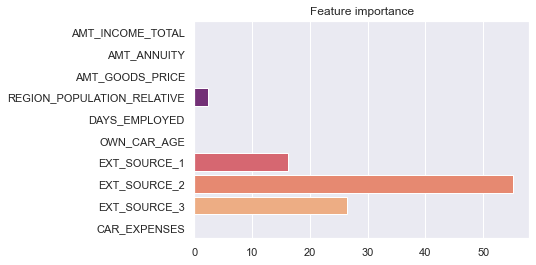

In [48]:
ax = sns.barplot(x=feature_importance, y=features, palette="magma")
ax.set_title("Feature importance");

__Выводы по `Feature importance`:__<br>
Значимость представляют следующие фичи (в порядке увеличения значимости)<br>
-->    `REGION_POPULATION_RELATIVE` ->
        `EXT_SOURCE_1` ->
            `EXT_SOURCE_3` ->
                `EXT_SOURCE_2`

# Stacking
---

In [49]:
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier

In [50]:
features, target

(['AMT_INCOME_TOTAL',
  'AMT_ANNUITY',
  'AMT_GOODS_PRICE',
  'REGION_POPULATION_RELATIVE',
  'DAYS_EMPLOYED',
  'OWN_CAR_AGE',
  'EXT_SOURCE_1',
  'EXT_SOURCE_2',
  'EXT_SOURCE_3',
  'CAR_EXPENSES'],
 ['TARGET'])

### Model 1. Random Forest

In [51]:
random_forest = RandomForestClassifier(n_estimators=10, random_state=42)

In [52]:
cross_validation(train, features, 'TARGET', RandomForestClassifier, n_estimators=10)

Fold: 1, AUC: 0.6392279226681306, LOG LOSS: 1.0446493133921408
Fold: 2, AUC: 0.6466255138263736, LOG LOSS: 1.014662503770737
Fold: 3, AUC: 0.6457297712063108, LOG LOSS: 1.0387424855252192
Fold: 4, AUC: 0.6358519184440772, LOG LOSS: 1.0543055278374918
Fold: 5, AUC: 0.6368916355716181, LOG LOSS: 1.0519045292047604
AV_AUC: 0.6408653523433021, AV_LOGLOSS: 1.0408528719460697


0.6408653523433021

### Model 2. CatBoost. Params from grid research

In [53]:
params_grid = {'depth': 5, 'l2_leaf_reg': 7, 'learning_rate': 0.3}

cat_boost_grid = CatBoostClassifier(**params_grid, iterations=100, random_seed=42, logging_level='Silent')

In [54]:
cross_validation(train, features, 'TARGET', CatBoostClassifier, **params_grid, iterations=100, logging_level='Silent')

Fold: 1, AUC: 0.7429605203974912, LOG LOSS: 0.24976844101558687
Fold: 2, AUC: 0.7431939458300727, LOG LOSS: 0.24967685471451725
Fold: 3, AUC: 0.7425769227979114, LOG LOSS: 0.25443126047921966
Fold: 4, AUC: 0.7419975076650315, LOG LOSS: 0.2484379639305417
Fold: 5, AUC: 0.7427635865840736, LOG LOSS: 0.2502125622878808
AV_AUC: 0.7426984966549159, AV_LOGLOSS: 0.25050541648554925


0.7426984966549159

### Model 3. CatBoost. Params from randomized search

In [62]:
params_random = {'depth': 3.0, 'learning_rate': 0.7191626472745672, 'l2_leaf_reg': 2.0}

cat_boost_random = CatBoostClassifier(**params_random, iterations=100, random_seed=42, logging_level='Silent')

In [63]:
cross_validation(train, features, 'TARGET', CatBoostClassifier, **params_random, iterations=100, logging_level='Silent')

Fold: 1, AUC: 0.7419151098891617, LOG LOSS: 0.2503139198423215
Fold: 2, AUC: 0.742715417477757, LOG LOSS: 0.24980919080159794
Fold: 3, AUC: 0.7411389947156599, LOG LOSS: 0.25504139815214016
Fold: 4, AUC: 0.740952279382361, LOG LOSS: 0.24908571411642286
Fold: 5, AUC: 0.7425116204079832, LOG LOSS: 0.250433136433624
AV_AUC: 0.7418466843745846, AV_LOGLOSS: 0.2509366718692213


0.7418466843745846

### Model 4. SGD

In [57]:
sgd = SGDClassifier()

In [58]:
cross_validation(train, features, 'TARGET', SGDClassifier, loss='log')

Fold: 1, AUC: 0.7203497565753134, LOG LOSS: 0.2561861623858514
Fold: 2, AUC: 0.7205159409693581, LOG LOSS: 0.25642166855387266
Fold: 3, AUC: 0.7218731136200763, LOG LOSS: 0.26002868963783043
Fold: 4, AUC: 0.7205889673122949, LOG LOSS: 0.2544154309792384
Fold: 5, AUC: 0.7230515109907005, LOG LOSS: 0.25552042371200445
AV_AUC: 0.7212758578935488, AV_LOGLOSS: 0.25651447505375946


0.7212758578935488

### Model 5. Logistic Regression

In [59]:
logic_reg = LogisticRegression(penalty='l2', C=0.5, class_weight='balanced')

In [60]:
cross_validation(train, features, 'TARGET', LogisticRegression, penalty='l2', C=0.5, class_weight='balanced')

Fold: 1, AUC: 0.724156406307308, LOG LOSS: 0.6150639733752424
Fold: 2, AUC: 0.7257160007484744, LOG LOSS: 0.614017256822107
Fold: 3, AUC: 0.7234946383040224, LOG LOSS: 0.6136195589258203
Fold: 4, AUC: 0.7207223851487556, LOG LOSS: 0.6123530578511427
Fold: 5, AUC: 0.7232739738546492, LOG LOSS: 0.6128659334861597
AV_AUC: 0.7234726808726419, AV_LOGLOSS: 0.6135839560920944


0.7234726808726419

## Stacking model 

In [64]:
X, y = train[features], train["TARGET"]
estimators = [
    ('random_forest', random_forest),
    ('logic_reg', logic_reg),
    ('cat_boost_grid', cat_boost_grid),
    ('cat_boost_random', cat_boost_random),
    ('sgd', sgd)
]

stack = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [65]:
score = stack.fit(X, y).predict_proba(test[features])

In [66]:
smpl_sub = pd.read_csv('../data/raw/sample_submission.csv') 
smpl_sub["TARGET"] = score[:, 1]
smpl_sub.to_csv("stackingModel.csv", index = False)

!kaggle competitions submit -c home-credit-default-risk -f stackingModel.csv -m "stackingModel"

100%|███████████████████████████████████████| 1.26M/1.26M [00:02<00:00, 644kB/s]
Successfully submitted to Home Credit Default Risk

### Public Score = 0.71951

## Remove the best score model -> model 2

In [67]:
X, y = train[features], train["TARGET"]
estimators = [
    ('random_forest', random_forest),
    ('cat_boost_random', cat_boost_random),
    ('sgd', sgd),
    ('logic_reg', logic_reg)
]

stack2 = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

In [68]:
score = stack2.fit(X, y).predict_proba(test[features])

In [69]:
smpl_sub = pd.read_csv('../data/raw/sample_submission.csv') 
smpl_sub["TARGET"] = score[:, 1]
smpl_sub.to_csv("stacking2.csv", index = False)

!kaggle competitions submit -c home-credit-default-risk -f stacking2.csv -m "stacking without best score model### Public Score = 0."

100%|███████████████████████████████████████| 1.26M/1.26M [00:01<00:00, 726kB/s]
Successfully submitted to Home Credit Default Risk

### Public Score = 0.71846

### Выводы по Стекингу:
После того, как из Стекинга убрали модель с лучшим результатом, качество итоговой модели уменьшилось на 0.001, что не так существенно. <br>
Стоит отметить, что при повторном (полный перезапуск jupyter notebook) расчете CatBoost grid_search и randomized_search лучшие параметры __grid__ не изменились, а вот лучшие параметры __randomized__ изменились и ухудшили качество модели.
